CoNLL-2003 dataset task demonstrates the labeling of tokens for named entity recognition (NER), part-of-speech (POS) tagging, and chunking. Each component of the JSON object corresponds to a different layer of annotation for the sentence:

1. **Tokens**: These are the individual words or punctuation marks from the text. In this case, the sentence "EU rejects German call to boycott British lamb." is split into tokens:
   - "EU"
   - "rejects"
   - "German"
   - "call"
   - "to"
   - "boycott"
   - "British"
   - "lamb"
   - "."

2. **POS Tags**: This array contains the POS tags corresponding to each token. The tags are encoded as numbers, each representing a specific part of speech (like noun, verb, adjective). These numbers usually correspond to a tagging scheme such as the Penn Treebank POS tags:
   - "EU" is tagged as 22, which represents a proper noun.
   - "rejects" is tagged as 42, indicating a verb in present tense.
   - And so forth.

3. **Chunk Tags**: This array indicates phrase chunk boundaries and types (like NP for noun phrase, VP for verb phrase). Each number again corresponds to a specific type of phrase or boundary in a predefined scheme:
   - "EU" is part of a noun phrase, hence 11.
   - "rejects" begins a verb phrase, indicated by 21.
   - The chunk tags help in parsing the sentence into linguistically meaningful phrases.

4. **NER Tags**: These tags are used for named entity recognition. They identify whether each token is part of a named entity (like a person, location, organization) and the type of entity:
   - "EU" is tagged as 3, denoting an organization.
   - "German" and "British" are tagged as 7, indicating nationality or ethnicity.
   - Other tokens are tagged as 0, meaning they are not recognized as part of any named entity.

 Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [32]:
!pip install uv
!uv pip install numpy pandas torch transformers datasets scikit-learn umap-learn matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Using Python 3.12.3 environment at: /home/jj/github/deepl_nlp/.venv
Audited 9 packages in 8ms


# Instructions 
1. download the **conll2003** from the following [link]("https://data.deepai.org/conll2003.zip")
2. unzip the file
3. download the glove embeddings from [link]("https://huggingface.co/datasets/SLU-CSCI4750/glove.6B.100d.txt/resolve/main/glove.6B.100d.txt.gz")
4. unzip the glove embeddings file
5. update the constants in the code below to point to the correct file paths on your machine

In [33]:
# basic python data science tooling
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import (
    Dataset, 
    DatasetDict, 
    Features, 
    Sequence, 
    ClassLabel, 
    Value,
)

# progress bar
from tqdm import tqdm


# deep learning stuff
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# constants for config
LOCAL_DIR = "/home/jj/github/deepl_nlp/assignment1/data/conll2003/"
GLOVE_EMBEDS_PATH = '/home/jj/github/deepl_nlp/assignment1/embeddings/glove.6B.100d.txt'

In [34]:
import random

def set_seed(seed=42):
    """
    Set seed for reproducibility across all random number generators.
    
    Args:
        seed: Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed before any model initialization or training
set_seed(42)

In [35]:
train_file = os.path.join(LOCAL_DIR, "train.txt")
valid_file = os.path.join(LOCAL_DIR, "valid.txt")
test_file = os.path.join(LOCAL_DIR, "test.txt")

pos_names = [
    '"',
    "''",
    "#",
    "$",
    "(",
    ")",
    ",",
    ".",
    ":",
    "``",
    "CC",
    "CD",
    "DT",
    "EX",
    "FW",
    "IN",
    "JJ",
    "JJR",
    "JJS",
    "LS",
    "MD",
    "NN",
    "NNP",
    "NNPS",
    "NNS",
    "NN|SYM",
    "PDT",
    "POS",
    "PRP",
    "PRP$",
    "RB",
    "RBR",
    "RBS",
    "RP",
    "SYM",
    "TO",
    "UH",
    "VB",
    "VBD",
    "VBG",
    "VBN",
    "VBP",
    "VBZ",
    "WDT",
    "WP",
    "WP$",
    "WRB",
]

chunk_names = [
    "O",
    "B-ADJP",
    "I-ADJP",
    "B-ADVP",
    "I-ADVP",
    "B-CONJP",
    "I-CONJP",
    "B-INTJ",
    "I-INTJ",
    "B-LST",
    "I-LST",
    "B-NP",
    "I-NP",
    "B-PP",
    "I-PP",
    "B-PRT",
    "I-PRT",
    "B-SBAR",
    "I-SBAR",
    "B-UCP",
    "I-UCP",
    "B-VP",
    "I-VP",
]

ner_names = [
    "O",
    "B-PER",
    "I-PER",
    "B-ORG",
    "I-ORG",
    "B-LOC",
    "I-LOC",
    "B-MISC",
    "I-MISC",
]


def parse_conll(path: str):
    """Parse a CoNLL-2003 file into a list of examples."""
    examples = []
    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            if line.startswith("-DOCSTART-") or line.strip() == "":
                if tokens:
                    examples.append(
                        {
                            "tokens": tokens,
                            "pos_tags": pos_tags,
                            "chunk_tags": chunk_tags,
                            "ner_tags": ner_tags,
                        }
                    )
                    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
            else:
                splits = line.rstrip().split(" ")
                tokens.append(splits[0])
                pos_tags.append(splits[1])
                chunk_tags.append(splits[2])
                ner_tags.append(splits[3])
    if tokens:
        examples.append(
            {
                "tokens": tokens,
                "pos_tags": pos_tags,
                "chunk_tags": chunk_tags,
                "ner_tags": ner_tags,
            }
        )
    return examples


def as_dataset(examples, features: Features):
    ids = []
    tokens_col, pos_col, chunk_col, ner_col = [], [], [], []
    for i, ex in enumerate(examples):
        ids.append(str(i))
        tokens_col.append(ex["tokens"])
        pos_col.append(ex["pos_tags"])
        chunk_col.append(ex["chunk_tags"])
        ner_col.append(ex["ner_tags"])
    return Dataset.from_dict(
        {
            "id": ids,
            "tokens": tokens_col,
            "pos_tags": pos_col,
            "chunk_tags": chunk_col,
            "ner_tags": ner_col,
        },
        features=features,
    )


features = Features(
    {
        "id": Value("string"),
        "tokens": Sequence(Value("string")),
        "pos_tags": Sequence(ClassLabel(names=pos_names)),
        "chunk_tags": Sequence(ClassLabel(names=chunk_names)),
        "ner_tags": Sequence(ClassLabel(names=ner_names)),
    }
)

train_examples = parse_conll(train_file)
valid_examples = parse_conll(valid_file)
test_examples = parse_conll(test_file)

conll2003 = DatasetDict(
    {
        "train": as_dataset(train_examples, features),
        "validation": as_dataset(valid_examples, features),
        "test": as_dataset(test_examples, features),
    }
)

display(conll2003)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [6]:
print(conll2003['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [36]:
def load_glove_embeddings(file_path, embedding_dim):
    # dict to store word embed vectors
    word_vectors = {}
    with open(file_path, 'r', encoding='utf - 8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor(
                [float(val) for val in values[1:]], dtype=torch.float32)
            word_vectors[word] = vector

    # matrix of embeddings
    vocab_size = len(word_vectors)
    embedding_matrix = torch.zeros((vocab_size, embedding_dim))
    word_to_idx = {}
    idx_to_word = {}
    for i, (word, vector) in enumerate(word_vectors.items()):
        embedding_matrix[i] = vector
        word_to_idx[word] = i
        idx_to_word[i] = word

    return embedding_matrix, word_to_idx, idx_to_word


embedding_dim = 100
embedding_matrix, word_to_idx, idx_to_word = load_glove_embeddings(GLOVE_EMBEDS_PATH, embedding_dim)


embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
embedding_layer

Embedding(400000, 100)

In [37]:
# Index for unknown tokens (out-of-vocabulary words not in GloVe)
UNK_IDX = len(word_to_idx)

def tokens_to_indices(tokens_batch):
    """
    Convert a batch of token sequences to their corresponding GloVe indices.
    Args:
        tokens_batch: List of token sequences (list of lists of strings)
    Returns:
        List of tensors containing token indices
    """
    indices = []
    for tokens in tokens_batch:
        # Look up each token (lowercased) in word_to_idx, use UNK_IDX if not found
        idxs = [
            word_to_idx.get(t.lower(), UNK_IDX) for t in tokens
        ]
        indices.append(torch.tensor(idxs, dtype=torch.long))
    return indices


def labels_to_tensors(labels_batch):
    """
    Convert a batch of NER label sequences to tensors.
    Args:
        labels_batch: List of label sequences (list of lists of ints)
    Returns:
        List of tensors containing label indices
    """
    return [torch.tensor(lbls, dtype=torch.long) for lbls in labels_batch]


def collate_fn(batch):
    """
    Collate function for DataLoader to batch and pad sequences.
    Args:
        batch: List of dataset samples, each with 'tokens' and 'ner_tags'
    Returns:
        Dictionary with padded 'input_ids' and 'labels' tensors
    """
    # Convert tokens to indices
    input_ids = tokens_to_indices([b["tokens"] for b in batch])
    
    # Convert NER tags to tensors
    labels = labels_to_tensors([b["ner_tags"] for b in batch])
    
    # Pad sequences to the same length within the batch
    # Padding value for input_ids is UNK_IDX (unknown token)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=UNK_IDX)
    
    # Padding value for labels is -100 (ignored by CrossEntropyLoss)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {"input_ids": input_ids, "labels": labels}


# Create DataLoaders for training, validation, and test sets
# batch_size=32: process 32 sequences at a time
# shuffle=True: randomly shuffle training data each epoch
train_dataloader = DataLoader(conll2003["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(conll2003["validation"], batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(conll2003["test"], batch_size=32, collate_fn=collate_fn)


In [9]:
class LinearNER(nn.Module):
    """
    Simple linear model for Named Entity Recognition using GloVe embeddings.
    Architecture: Embedding -> Linear -> Logits
    """
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int):
        super().__init__()
        # if you use 100-dimensional GloVe vectors for a 50,000-word vocabulary,
        # vocab_size would be 50,000 and embed_dim would be 100.
        vocab_size, embed_dim = embedding_matrix.shape
        
        # Create embedding layer with extra slot for unknown tokens (UNK)
        # nn.Embedding is just a big lookup table. It stores a vector for each word index.
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        
        # Initialize embeddings with pre-trained GloVe vectors
        # The last row (index vocab_size) is reserved for UNK tokens and initialized to zeros
        # .no_grad() tells PyTorch not to track gradients for the next steps.
        # This is important because we are just initializing the weights, not training them yet.
        with torch.no_grad():
            # Copies the pre-trained embedding_matrix (your GloVe vectors) into the embedding layer's weight table.
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        
        # Linear classifier maps embedding dimension to number of NER tags
        # This is the model's "brain." It's a single linear (or "fully-connected") layer.
        self.classifier = nn.Linear(embed_dim, num_tags)

    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, sequence_length) - token indices
        Returns:
            logits: (batch_size, sequence_length, num_tags) - unnormalized scores for each tag
        """
        # input_ids is a batch of sentences, where each word is an index (e.g., [[10, 45, 132], [7, 500, 9]]).
        # This line looks up the embedding vector for every single index.
        # If the input shape is (Batch_Size, Sequence_Length), the output emb shape is (Batch_Size, Sequence_Length, Embedding_Dimension).
        emb = self.embedding(input_ids)           # (B, T, D) - embed each token
        # This applies the same linear layer to each token's embedding in the sequence
        # logits = raw scores like [1.2, -0.5, 3.1, 0.1]
        # (Batch_Size, Sequence_Length, Num_Tags)
        logits = self.classifier(emb)             # (B, T, C) - project to tag space
        return logits


# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# Initialize model with pre-trained GloVe embeddings
model = LinearNER(embedding_matrix, num_tags)

# CrossEntropyLoss with ignore_index=-100 to skip padding tokens in loss calculation
# its also very comoda perchè prende i logit e le label
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Adam optimizer for parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# to confront models
linear_epochs = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    
    # An epoch is too large to process at once, so it's broken into smaller chunks
    # called batches (handled by the train_dataloader)
    for batch in train_dataloader:
        # Move batch data to device (gpu)
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        # Zero gradients from previous step
        # This line clears the gradients from the previous batch,
        # ensuring we only update the model based on the current batch's error.
        optimizer.zero_grad()
        
        # Forward pass: get predictions
        logits = model(input_ids)
        
        # Compute loss (flatten to 2D for CrossEntropyLoss: [batch*seq_len, num_tags])
        # The model output logits is 3D: (B, T, C).
        # The labels are 2D: (B, T).
        #
        # CrossEntropyLoss expects 2D logits (N, C) and 1D labels (N), where N is the total number of items.
        #
        # logits.view(-1, num_tags): This "flattens" the (B, T, C) tensor into (B*T, C). It essentially makes one giant list of all the tokens in the batch.
        # labels.view(-1): This flattens the (B, T) tensor into (B*T).
        #
        # Now, the loss function compares the logits for every single token against its corresponding true label. Thanks to ignore_index=-100, any token where the label is -100 is skipped.
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss for monitoring
        total_loss += loss.item()
    
    # Print average loss per batch for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    linear_epochs.append(total_loss/len(train_dataloader))


Epoch 1/5 - Train Loss: 0.6352
Epoch 2/5 - Train Loss: 0.2944
Epoch 3/5 - Train Loss: 0.2166
Epoch 4/5 - Train Loss: 0.1810
Epoch 5/5 - Train Loss: 0.1614


Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

### functions to extract entities and calculate metrics at entity level

In [38]:
"""
why is this necessary?
Token-level vs Entity-level evaluation are VERY different:

Token-level (simpler but less meaningful):
  Evaluates each token independently
  If you predict [B-PER, O, O] instead of [B-PER, I-PER, O], you get 2/3 = 66% accuracy
  Problem: This doesn't tell you if you correctly identified complete entities!
    
Entity-level (what NER really cares about):
  An entity is only correct if both the entity type AND the complete span match exactly
  If you predict "Mario" as B-PER but miss "Draghi" (I-PER), you get:
  Predicted: 1 incomplete entity
  True: 1 complete entity
  Result: 0% match because the spans don't match exactly

"""
def get_entities(tags, tag_names):
    """
    Extract named entities from a sequence of NER tags using BIO tagging scheme.
    BIO scheme: B-TYPE (begin), I-TYPE (inside), O (outside)
    
    Args:
        tags: Sequence of tag IDs
        tag_names: List mapping tag IDs to tag names (e.g., ['O', 'B-PER', 'I-PER', ...])
    Returns:
        Set of tuples: (entity_type, start_idx, end_idx) for each entity found
    """
    entities = []
    current_entity = None
    
    for i, tag_id in enumerate(tags):
        if tag_id == -100:
            continue
        tag = tag_names[tag_id]
        
        if tag.startswith('B-'):
            # B- tag starts a new entity
            if current_entity is not None:
                entities.append(current_entity)
            # skips the 'B-'
            entity_type = tag[2:]
            current_entity = (entity_type, i, i)
        elif tag.startswith('I-'):
            # I- tag continues the current entity
            entity_type = tag[2:]
            if current_entity is not None and current_entity[0] == entity_type:
                # Extend current entity to include this token
                current_entity = (current_entity[0], current_entity[1], i)
            else:
                # Mismatched I- tag (e.g., I-PER after B-ORG), treat as new entity
                if current_entity is not None:
                    entities.append(current_entity)
                current_entity = (entity_type, i, i)
        else:
            # O tag ends the current entity
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None
    
    # Save the last entity if sequence ended while inside an entity
    if current_entity is not None:
        entities.append(current_entity)
    
    return set(entities)

def compute_entity_f1(model, dataloader, tag_names, device):
    """
    Compute entity-level precision, recall, and F1 score.
    Entity-level: an entity is correct only if both type and span match exactly.
    
    Args:
        model: Trained NER model
        dataloader: DataLoader with evaluation data
        tag_names: List of NER tag names
        device: Device to run evaluation on (CPU/GPU)
    Returns:
        Dictionary with precision, recall, F1, and counts
    """
    model.eval()
    
    all_true_entities = []
    all_pred_entities = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            # Get model predictions
            logits = model(input_ids)
            predictions = torch.argmax(logits, dim=-1)
            
            # Process each sequence in the batch
            for pred_seq, true_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                # Extract entities from predicted and true sequences
                true_entities = get_entities(true_seq, tag_names)
                pred_entities = get_entities(pred_seq, tag_names)
                # now we have ordered lists of entities for both true and predicted
                # which can be compared easily with set operations
                all_true_entities.append(true_entities)
                all_pred_entities.append(pred_entities)
    
    # Calculate entity-level metrics
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for true_ents, pred_ents in zip(all_true_entities, all_pred_entities):
        # Intersection: entities present in both true and predicted
        true_positives += len(true_ents & pred_ents)
        # Predicted but not in ground truth
        false_positives += len(pred_ents - true_ents)
        # In ground truth but not predicted
        false_negatives += len(true_ents - pred_ents)
    
    # Compute precision, recall, and F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }


tag_names = conll2003["train"].features["ner_tags"].feature.names

def entity_level_evaluation(model, val_dataloader=val_dataloader, test_dataloader=test_dataloader, tag_names=tag_names, device=device, verbose=True):
    """
    Evaluate model and optionally print results.
    Returns: dict with 'val' and 'test' metrics
    """
    val_metrics = compute_entity_f1(model, val_dataloader, tag_names, device)
    test_metrics = compute_entity_f1(model, test_dataloader, tag_names, device)
    
    if verbose:
        print("=" * 60)
        print("Entity-level Evaluation on Validation Set")
        print("-" * 60)
        print(f"Precision: {val_metrics['precision']:.4f}")
        print(f"Recall:    {val_metrics['recall']:.4f}")
        print(f"F1 Score:  {val_metrics['f1']:.4f}")
        print(f"\nTrue Positives:  {val_metrics['true_positives']}")
        print(f"False Positives: {val_metrics['false_positives']}")
        print(f"False Negatives: {val_metrics['false_negatives']}")

        print("\n" + "-" * 60)
        print("Entity-level Evaluation on Test Set")
        print("=" * 60)
        print(f"Precision: {test_metrics['precision']:.4f}")
        print(f"Recall:    {test_metrics['recall']:.4f}")
        print(f"F1 Score:  {test_metrics['f1']:.4f}")
        print(f"\nTrue Positives:  {test_metrics['true_positives']}")
        print(f"False Positives: {test_metrics['false_positives']}")
        print(f"False Negatives: {test_metrics['false_negatives']}")
    
    return {'val': val_metrics, 'test': test_metrics}

entity_level_evaluation(model);

Evaluating: 100%|██████████| 108/108 [00:00<00:00, 625.32it/s]

Entity-level Evaluation on Validation Set
------------------------------------------------------------
Precision: 0.3986
Recall:    0.2189
F1 Score:  0.2826

True Positives:  1301
False Positives: 1963
False Negatives: 4641

------------------------------------------------------------
Entity-level Evaluation on Test Set
Precision: 0.4106
Recall:    0.2049
F1 Score:  0.2733

True Positives:  1157
False Positives: 1661
False Negatives: 4491


### some classic token level evaluation w/ confusion matrix

In [66]:
from sklearn.metrics import classification_report as sklearn_classification_report
from collections import defaultdict

def get_token_level_predictions(model, dataloader, device):
    """
    Get all token-level predictions and labels (excluding padding).
    
    Args:
        model: Trained NER model
        dataloader: DataLoader with evaluation data
        device: Device to run evaluation on
    Returns:
        Tuple of (all_labels, all_preds) as numpy arrays
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting token predictions"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids)
            predictions = torch.argmax(logits, dim=-1)
            
            # Flatten and filter out padding tokens
            for pred_seq, label_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                for pred, label in zip(pred_seq, label_seq):
                    if label != -100:  # Skip padding tokens
                        all_preds.append(pred)
                        all_labels.append(label)
    
    return np.array(all_labels), np.array(all_preds)


# Get token-level predictions for test set
print("Collecting token-level predictions for test set...")
test_labels, test_preds = get_token_level_predictions(model, test_dataloader, device)

# Token-level classification report for test set
print("\n" + "=" * 60)
print("Token-level Classification Report (Test Set)")
print("=" * 60)
print(sklearn_classification_report(test_labels, test_preds, digits=4))

# Get token-level predictions for validation set
print("\nCollecting token-level predictions for validation set...")
val_labels, val_preds = get_token_level_predictions(model, val_dataloader, device)

# Token-level classification report for validation set
print("\n" + "=" * 60)
print("Token-level Classification Report (Validation Set)")
print("=" * 60)
print(sklearn_classification_report(val_labels, val_preds, digits=4))

Getting token predictions: 100%|██████████| 108/108 [00:00<00:00, 765.86it/s]



Token-level Classification Report (Test Set)
              precision    recall  f1-score   support

           0     0.9646    0.9810    0.9727     38323
           1     0.7225    0.6537    0.6864      1617
           2     0.5757    0.5528    0.5640      1156
           3     0.6939    0.5828    0.6335      1661
           4     0.4792    0.3030    0.3712       835
           5     0.7214    0.8351    0.7741      1668
           6     0.5689    0.4981    0.5311       257
           7     0.6510    0.6111    0.6304       702
           8     0.6510    0.4491    0.5315       216

    accuracy                         0.9165     46435
   macro avg     0.6698    0.6074    0.6328     46435
weighted avg     0.9109    0.9165    0.9128     46435




Getting token predictions: 100%|██████████| 102/102 [00:00<00:00, 729.79it/s]



Token-level Classification Report (Validation Set)
              precision    recall  f1-score   support

           0     0.9682    0.9864    0.9772     42759
           1     0.8036    0.7286    0.7642      1842
           2     0.6286    0.6435    0.6359      1307
           3     0.7006    0.6771    0.6887      1341
           4     0.5201    0.2929    0.3748       751
           5     0.8387    0.8323    0.8355      1837
           6     0.6250    0.5447    0.5821       257
           7     0.7488    0.6985    0.7228       922
           8     0.6049    0.2832    0.3858       346

    accuracy                         0.9326     51362
   macro avg     0.7154    0.6319    0.6630     51362
weighted avg     0.9274    0.9326    0.9290     51362



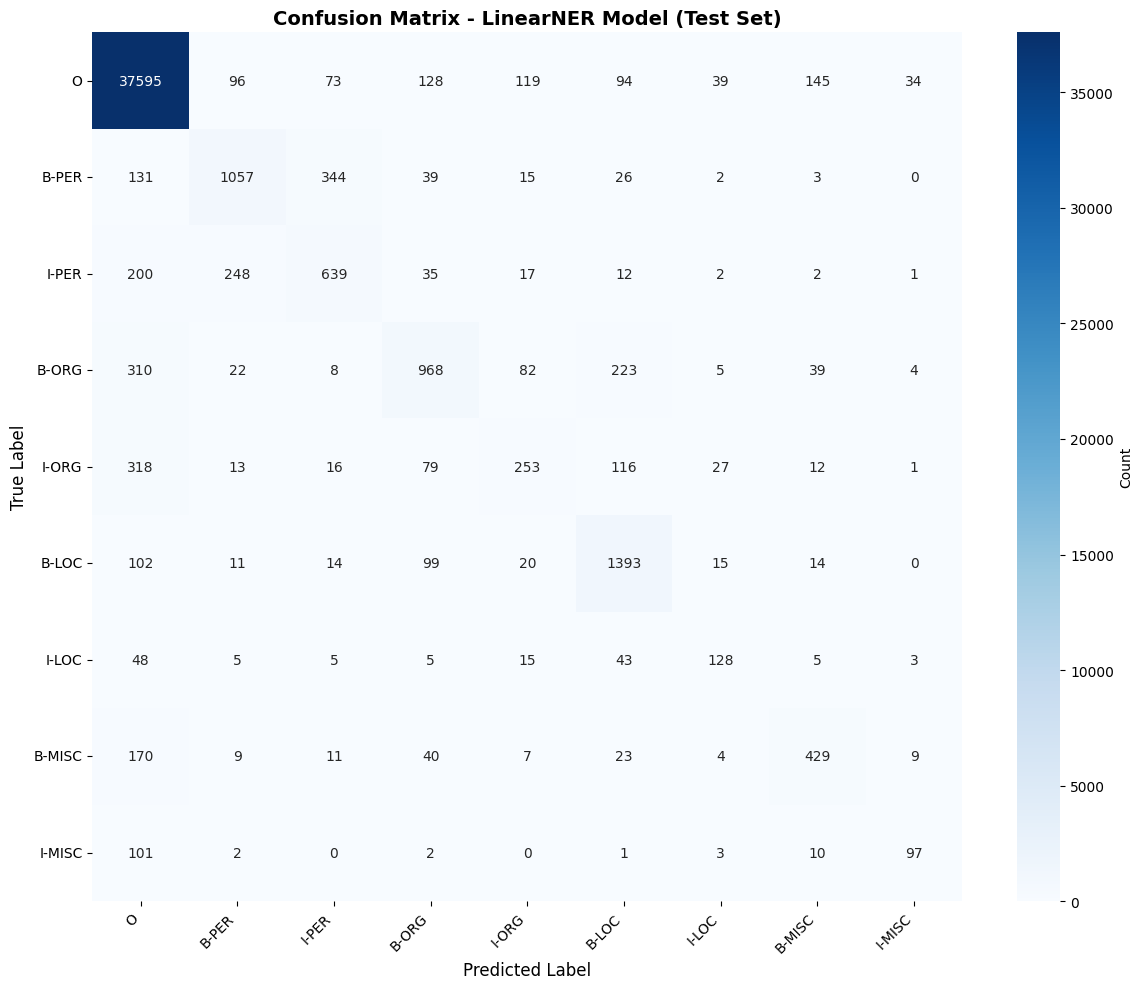


Top 10 Most Common Prediction Errors
True: B-PER      -> Predicted: I-PER      | Count: 344
True: I-ORG      -> Predicted: O          | Count: 318
True: B-ORG      -> Predicted: O          | Count: 310
True: I-PER      -> Predicted: B-PER      | Count: 248
True: B-ORG      -> Predicted: B-LOC      | Count: 223
True: I-PER      -> Predicted: O          | Count: 200
True: B-MISC     -> Predicted: O          | Count: 170
True: O          -> Predicted: B-MISC     | Count: 145
True: B-PER      -> Predicted: O          | Count: 131
True: O          -> Predicted: B-ORG      | Count: 128


In [67]:
# Token-level confusion matrix visualization
from sklearn.metrics import confusion_matrix

# Confusion matrix for test set
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tag_names, yticklabels=tag_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - LinearNER Model (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze most common errors
print("\n" + "=" * 60)
print("Top 10 Most Common Prediction Errors")
print("=" * 60)
errors = []
for i in range(len(tag_names)):
    for j in range(len(tag_names)):
        if i != j and cm[i, j] > 0:
            errors.append((tag_names[i], tag_names[j], cm[i, j]))

errors.sort(key=lambda x: x[2], reverse=True)
for true_tag, pred_tag, count in errors[:10]:
    print(f"True: {true_tag:10s} -> Predicted: {pred_tag:10s} | Count: {count}")

very easy to predict a wrong O whenn there are so many

idee: see relative rates for each miscalculated label. like a confusion matrix but with percentages

2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 1

## MLPs

In [39]:
class MLPNER(nn.Module):
    """
    Multi-layer perceptron for Named Entity Recognition using GloVe embeddings.
    Architecture: Embedding -> MLP (hidden layers) -> Logits
    """
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int, 
                 hidden_dims: list = [256, 128], dropout: float = 0.5):
        """
        Args:
            embedding_matrix: Pre-trained GloVe embeddings
            num_tags: Number of NER tags (end dimension)
            hidden_dims: List of hidden layer dimensions (e.g., [256, 128] for 2 layers)
            dropout: Dropout probability for regularization, 0.5 because the paper I think used that
        """
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        
        # Embedding layer (same as before)
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        with torch.no_grad():
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        
        # Build MLP layers using nn.Sequential
        # i love it
        layers = []
        input_dim = embed_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        # L'asterisco * è l'operatore di "unpacking" (spacchettamento) di Python.
        # Prende la lista layers e "spacchetta" il suo contenuto, passando ogni elemento
        # della lista come un argomento separato a nn.Sequential
        self.mlp = nn.Sequential(*layers)
        
        # Final classifier
        self.classifier = nn.Linear(input_dim, num_tags)
    
    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, sequence_length)
        Returns:
            logits: (batch_size, sequence_length, num_tags)
        """
        # using the glove embeddings
        emb = self.embedding(input_ids)        # (B, T, D)
        # pass through MLP
        hidden = self.mlp(emb)                 # (B, T, H)
        # pass through final classifier
        logits = self.classifier(hidden)       # (B, T, C)
        return logits

def train_model(model, train_dataloader, num_epochs=5, lr=1e-3, device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
, model_name="Model"):
    """
    Train a NER model and return training losses per epoch.
    
    Args:
        model: The model to train
        train_dataloader: DataLoader for training data
        num_epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on
        model_name: Name for logging
    
    Returns:
        List of average losses per epoch
    """
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    epoch_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for batch in tqdm(train_dataloader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.4f}")
    
    return epoch_losses

[256,128]

In [69]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# Initialize model with pre-trained GloVe embeddings
# using defaults this is now a 2-layer MLP with 256 and 128 hidden units
model_2layer = MLPNER(embedding_matrix, num_tags)

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 2-layer MLP model
mlp_2layer_epochs = train_model(model_2layer, train_dataloader, model_name="MLP-2Layer")

MLP-2Layer - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 72.13it/s]


MLP-2Layer - Epoch 1/5 - Train Loss: 0.4126


MLP-2Layer - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 72.32it/s]


MLP-2Layer - Epoch 2/5 - Train Loss: 0.2390


MLP-2Layer - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 72.35it/s]


MLP-2Layer - Epoch 3/5 - Train Loss: 0.2033


MLP-2Layer - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 72.35it/s]


MLP-2Layer - Epoch 4/5 - Train Loss: 0.1858


MLP-2Layer - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 72.27it/s]

MLP-2Layer - Epoch 5/5 - Train Loss: 0.1729


[128]

In [70]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_onelayer = MLPNER(embedding_matrix, num_tags, hidden_dims=[128])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 1-layer MLP model
mlp_onelayer_epochs = train_model(model_onelayer, train_dataloader, model_name="MLP-1Layer")

MLP-1Layer - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 72.98it/s]


MLP-1Layer - Epoch 1/5 - Train Loss: 0.4383


MLP-1Layer - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 72.95it/s]


MLP-1Layer - Epoch 2/5 - Train Loss: 0.2387


MLP-1Layer - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 72.70it/s]


MLP-1Layer - Epoch 3/5 - Train Loss: 0.1992


MLP-1Layer - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 73.07it/s]


MLP-1Layer - Epoch 4/5 - Train Loss: 0.1786


MLP-1Layer - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 72.14it/s]

MLP-1Layer - Epoch 5/5 - Train Loss: 0.1660


[512,256,128]

In [40]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer = MLPNER(embedding_matrix, num_tags, hidden_dims=[512,256,128])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 3-layer MLP model
mlp_3layer_epochs = train_model(model_3layer, train_dataloader, model_name="MLP-3Layer")

MLP-3Layer - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 71.07it/s]


MLP-3Layer - Epoch 1/5 - Train Loss: 0.3940


MLP-3Layer - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 71.10it/s]


MLP-3Layer - Epoch 2/5 - Train Loss: 0.2398


MLP-3Layer - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 69.46it/s]


MLP-3Layer - Epoch 3/5 - Train Loss: 0.2072


MLP-3Layer - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 69.19it/s]


MLP-3Layer - Epoch 4/5 - Train Loss: 0.1890


MLP-3Layer - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 68.13it/s]

MLP-3Layer - Epoch 5/5 - Train Loss: 0.1775


[512,256,256]

In [76]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer_wide = MLPNER(embedding_matrix, num_tags, hidden_dims=[512,256,256])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 3-layer MLP model
mlp_3layer_wide_epochs = train_model(model_3layer_wide, train_dataloader, model_name="MLP-3Layer-wide")

MLP-3Layer-wide - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 70.74it/s]


MLP-3Layer-wide - Epoch 1/5 - Train Loss: 0.3921


MLP-3Layer-wide - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 70.71it/s]


MLP-3Layer-wide - Epoch 2/5 - Train Loss: 0.2331


MLP-3Layer-wide - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 70.72it/s]


MLP-3Layer-wide - Epoch 3/5 - Train Loss: 0.2011


MLP-3Layer-wide - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 71.55it/s]


MLP-3Layer-wide - Epoch 4/5 - Train Loss: 0.1861


MLP-3Layer-wide - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 71.53it/s]

MLP-3Layer-wide - Epoch 5/5 - Train Loss: 0.1730


[128,128,128]

In [77]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer_small = MLPNER(embedding_matrix, num_tags, hidden_dims=[128,128,128])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 3-layer MLP model
mlp_3layer_small_epochs = train_model(model_3layer_small, train_dataloader, model_name="MLP-3Layer-small")

MLP-3Layer-small - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 71.32it/s]


MLP-3Layer-small - Epoch 1/5 - Train Loss: 0.4775


MLP-3Layer-small - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 71.92it/s]


MLP-3Layer-small - Epoch 2/5 - Train Loss: 0.2752


MLP-3Layer-small - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 72.04it/s]


MLP-3Layer-small - Epoch 3/5 - Train Loss: 0.2368


MLP-3Layer-small - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 71.07it/s]


MLP-3Layer-small - Epoch 4/5 - Train Loss: 0.2127


MLP-3Layer-small - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 71.72it/s]

MLP-3Layer-small - Epoch 5/5 - Train Loss: 0.1974


[512]

In [78]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_onelayer_wide = MLPNER(embedding_matrix, num_tags, hidden_dims=[512])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 1-layer MLP model
mlp_onelayer_wide_epochs = train_model(model_onelayer_wide, train_dataloader, model_name="MLP-oneLayer_wide")

MLP-oneLayer_wide - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 72.28it/s]


MLP-oneLayer_wide - Epoch 1/5 - Train Loss: 0.3504


MLP-oneLayer_wide - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 71.99it/s]


MLP-oneLayer_wide - Epoch 2/5 - Train Loss: 0.2049


MLP-oneLayer_wide - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 72.30it/s]


MLP-oneLayer_wide - Epoch 3/5 - Train Loss: 0.1762


MLP-oneLayer_wide - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 72.45it/s]


MLP-oneLayer_wide - Epoch 4/5 - Train Loss: 0.1614


MLP-oneLayer_wide - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 72.48it/s]

MLP-oneLayer_wide - Epoch 5/5 - Train Loss: 0.1527


il 3-layer descending layer size didnt perform as good as i would have thought

[256,64,128]

In [82]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer_bottleneck = MLPNER(embedding_matrix, num_tags, hidden_dims=[256,64,128])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 3-layer MLP model
mlp_3layer_bottleneck_epochs = train_model(model_3layer_bottleneck, train_dataloader, model_name="MLP-3Layer-bottleneck")

MLP-3Layer-bottleneck - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 71.76it/s]


MLP-3Layer-bottleneck - Epoch 1/5 - Train Loss: 0.4667


MLP-3Layer-bottleneck - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 71.67it/s]


MLP-3Layer-bottleneck - Epoch 2/5 - Train Loss: 0.2724


MLP-3Layer-bottleneck - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 71.79it/s]


MLP-3Layer-bottleneck - Epoch 3/5 - Train Loss: 0.2393


MLP-3Layer-bottleneck - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 71.80it/s]


MLP-3Layer-bottleneck - Epoch 4/5 - Train Loss: 0.2173


MLP-3Layer-bottleneck - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 72.04it/s]

MLP-3Layer-bottleneck - Epoch 5/5 - Train Loss: 0.2016


[256,128,64,32,16]

In [84]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_5layers_bottleneck = MLPNER(embedding_matrix, num_tags, hidden_dims=[256,128,64,32,16])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 5-layer MLP model
mlp_5layers_bottleneck_epochs = train_model(model_5layers_bottleneck, train_dataloader, model_name="MLP-5Layers-bottleneck")

MLP-5Layers-bottleneck - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 70.65it/s]


MLP-5Layers-bottleneck - Epoch 1/5 - Train Loss: 0.6782


MLP-5Layers-bottleneck - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 70.69it/s]


MLP-5Layers-bottleneck - Epoch 2/5 - Train Loss: 0.4270


MLP-5Layers-bottleneck - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 70.85it/s]


MLP-5Layers-bottleneck - Epoch 3/5 - Train Loss: 0.3849


MLP-5Layers-bottleneck - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 70.99it/s]


MLP-5Layers-bottleneck - Epoch 4/5 - Train Loss: 0.3530


MLP-5Layers-bottleneck - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 70.67it/s]

MLP-5Layers-bottleneck - Epoch 5/5 - Train Loss: 0.3387


In [85]:
# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_5layers = MLPNER(embedding_matrix, num_tags, hidden_dims=[512,256,128,64,32])

# Set seed for reproducibility
set_seed(42)
        
# Clear GPU cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Train the 5-layer MLP model
mlp_5layers_epochs = train_model(model_5layers, train_dataloader, model_name="MLP-5Layers")

MLP-5Layers - Epoch 1/5: 100%|██████████| 439/439 [00:06<00:00, 70.32it/s]


MLP-5Layers - Epoch 1/5 - Train Loss: 0.5429


MLP-5Layers - Epoch 2/5: 100%|██████████| 439/439 [00:06<00:00, 69.16it/s]


MLP-5Layers - Epoch 2/5 - Train Loss: 0.3526


MLP-5Layers - Epoch 3/5: 100%|██████████| 439/439 [00:06<00:00, 69.99it/s]


MLP-5Layers - Epoch 3/5 - Train Loss: 0.2986


MLP-5Layers - Epoch 4/5: 100%|██████████| 439/439 [00:06<00:00, 70.54it/s]


MLP-5Layers - Epoch 4/5 - Train Loss: 0.2758


MLP-5Layers - Epoch 5/5: 100%|██████████| 439/439 [00:06<00:00, 70.59it/s]

MLP-5Layers - Epoch 5/5 - Train Loss: 0.2599


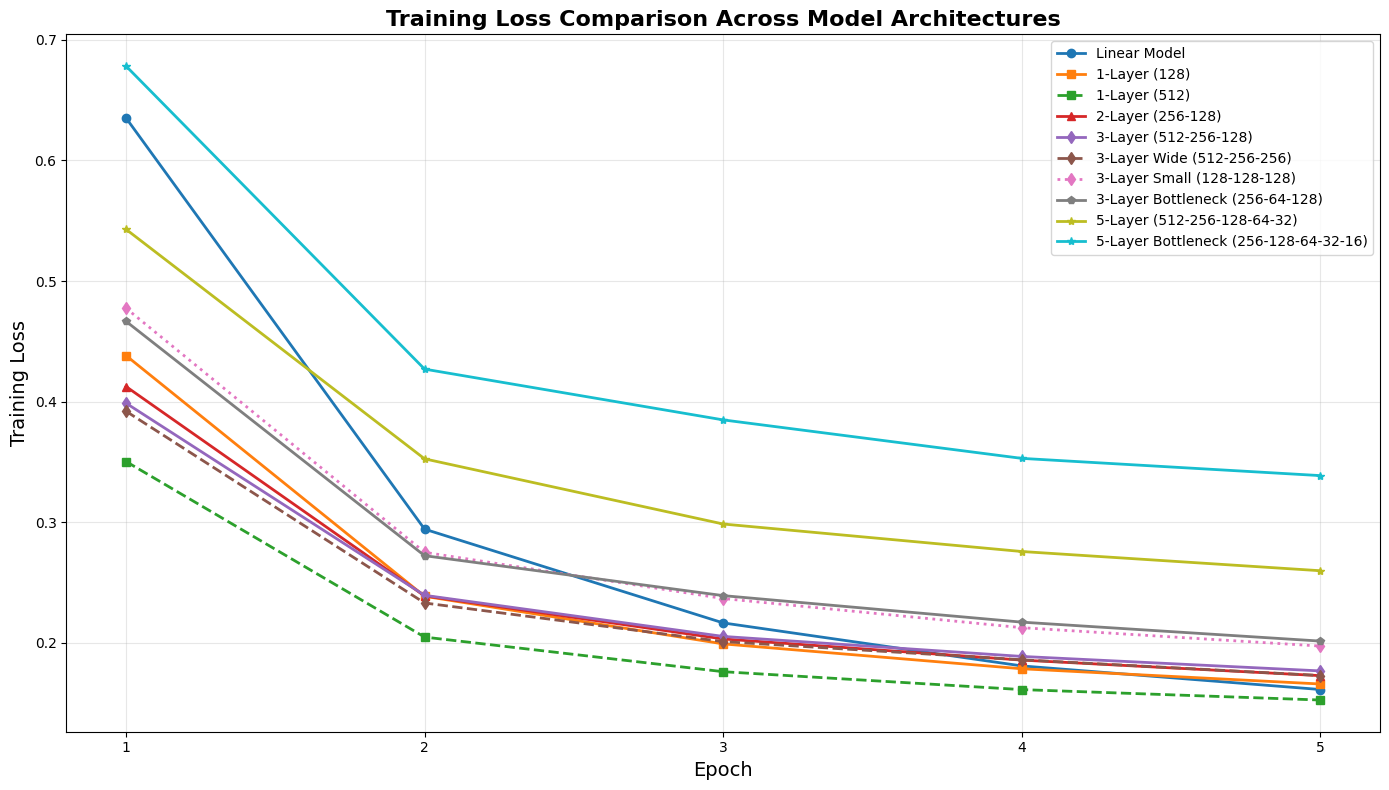

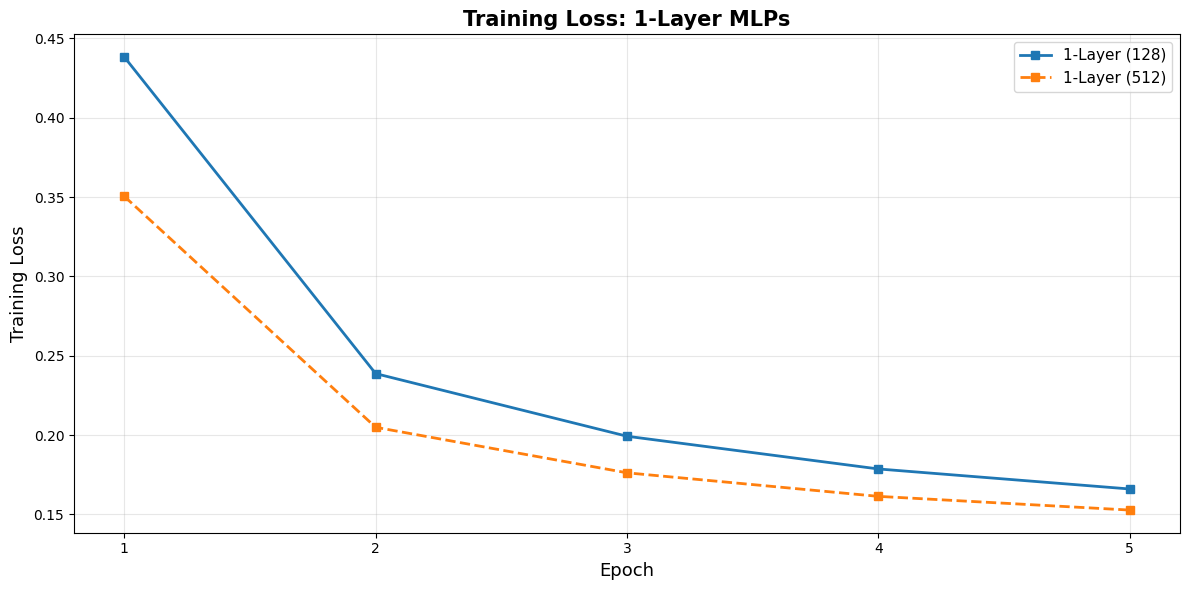

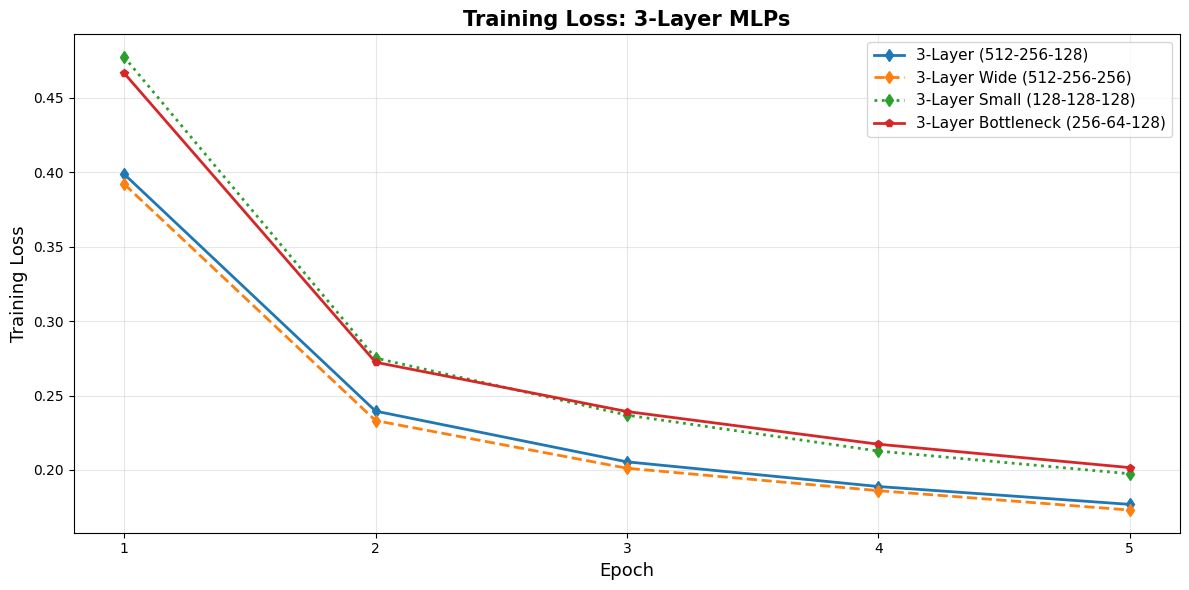

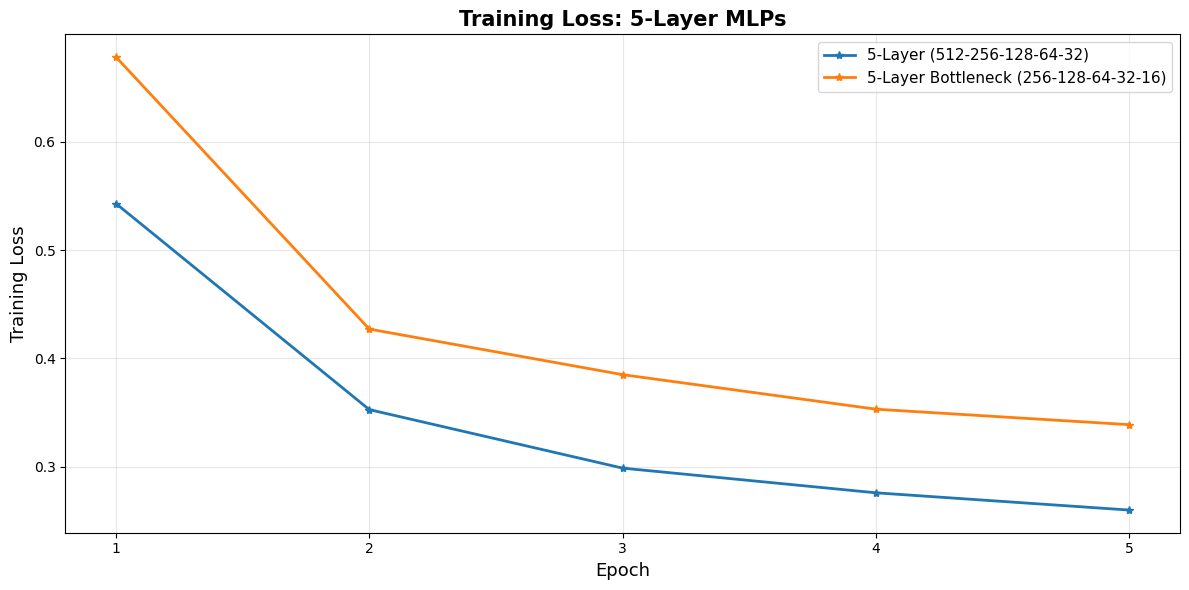


Final Training Loss (Epoch 5)
Linear Model:                0.1614
1-Layer (128):           0.1660
1-Layer (512):           0.1527
2-Layer (256-128):       0.1729
3-Layer (512-256-128):   0.1768
3-Layer Wide (512-256-256):  0.1730
3-Layer Small (128-128-128):        0.1974
3-Layer Bottleneck (256-64-128):          0.2016
5-Layer (512-256-128-64-32): 0.2599
5-Layer Bottleneck (256-128-64-32-16): 0.3387
------------------------------------------------------------
in descending order of final training loss:
------------------------------------------------------------
1-Layer (512): 0.1527
Linear Model: 0.1614
1-Layer (128): 0.1660
2-Layer (256-128): 0.1729
3-Layer Wide (512-256-256): 0.1730
3-Layer (512-256-128): 0.1768
3-Layer Small (128-128-128): 0.1974
3-Layer Bottleneck (256-64-128): 0.2016
5-Layer (512-256-128-64-32): 0.2599
5-Layer Bottleneck (256-128-64-32-16): 0.3387


In [ ]:
# Visualize training loss for all models
plt.figure(figsize=(14, 8))

# Plot each model's training loss
plt.plot(range(1, num_epochs + 1), linear_epochs, marker='o', label='Linear Model', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_onelayer_epochs, marker='s', label='1-Layer (128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_onelayer_wide_epochs, marker='s', label='1-Layer (512)', linewidth=2, linestyle='--')
plt.plot(range(1, num_epochs + 1), mlp_2layer_epochs, marker='^', label='2-Layer (256-128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_3layer_epochs, marker='d', label='3-Layer (512-256-128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_3layer_wide_epochs, marker='d', label='3-Layer Wide (512-256-256)', linewidth=2, linestyle='--')
plt.plot(range(1, num_epochs + 1), mlp_3layer_small_epochs, marker='d', label='3-Layer Small (128-128-128)', linewidth=2, linestyle=':')
plt.plot(range(1, num_epochs + 1), mlp_3layer_bottleneck_epochs, marker='p', label='3-Layer Bottleneck (256-64-128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_5layers_epochs, marker='*', label='5-Layer (512-256-128-64-32)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_5layers_bottleneck_epochs, marker='*', label='5-Layer Bottleneck (256-128-64-32-16)', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.title('Training Loss Comparison Across Model Architectures', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# Separate plots focusing on models with same amount of layers
# 1-Layer MLPs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), mlp_onelayer_epochs, marker='s', label='1-Layer (128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_onelayer_wide_epochs, marker='s', label='1-Layer (512)', linewidth=2, linestyle='--')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Training Loss: 1-Layer MLPs', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# 3-Layer MLPs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), mlp_3layer_epochs, marker='d', label='3-Layer (512-256-128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_3layer_wide_epochs, marker='d', label='3-Layer Wide (512-256-256)', linewidth=2, linestyle='--')
plt.plot(range(1, num_epochs + 1), mlp_3layer_small_epochs, marker='d', label='3-Layer Small (128-128-128)', linewidth=2, linestyle=':')
plt.plot(range(1, num_epochs + 1), mlp_3layer_bottleneck_epochs, marker='p', label='3-Layer Bottleneck (256-64-128)', linewidth=2)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Training Loss: 3-Layer MLPs', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# 5-Layer MLPs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), mlp_5layers_epochs, marker='*', label='5-Layer (512-256-128-64-32)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_5layers_bottleneck_epochs, marker='*', label='5-Layer Bottleneck (256-128-64-32-16)', linewidth=2)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Training Loss: 5-Layer MLPs', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# Print final losses for comparison
print("\n" + "=" * 60)
print("Final Training Loss (Epoch 5)")
print("=" * 60)
print(f"Linear Model:                {linear_epochs[-1]:.4f}")
print(f"1-Layer (128):           {mlp_onelayer_epochs[-1]:.4f}")
print(f"1-Layer (512):           {mlp_onelayer_wide_epochs[-1]:.4f}")
print(f"2-Layer (256-128):       {mlp_2layer_epochs[-1]:.4f}")
print(f"3-Layer (512-256-128):   {mlp_3layer_epochs[-1]:.4f}")
print(f"3-Layer Wide (512-256-256):  {mlp_3layer_wide_epochs[-1]:.4f}")
print(f"3-Layer Small (128-128-128):        {mlp_3layer_small_epochs[-1]:.4f}")
print(f"3-Layer Bottleneck (256-64-128):          {mlp_3layer_bottleneck_epochs[-1]:.4f}")
print(f"5-Layer (512-256-128-64-32): {mlp_5layers_epochs[-1]:.4f}")
print(f"5-Layer Bottleneck (256-128-64-32-16): {mlp_5layers_bottleneck_epochs[-1]:.4f}")

# now print it in descending order by value
final_losses = {
    "Linear Model": linear_epochs[-1],
    "1-Layer (128)": mlp_onelayer_epochs[-1],
    "1-Layer (512)": mlp_onelayer_wide_epochs[-1],
    "2-Layer (256-128)": mlp_2layer_epochs[-1],
    "3-Layer (512-256-128)": mlp_3layer_epochs[-1],
    "3-Layer Wide (512-256-256)": mlp_3layer_wide_epochs[-1],
    "3-Layer Small (128-128-128)": mlp_3layer_small_epochs[-1],
    "3-Layer Bottleneck (256-64-128)": mlp_3layer_bottleneck_epochs[-1],
    "5-Layer (512-256-128-64-32)": mlp_5layers_epochs[-1],
    "5-Layer Bottleneck (256-128-64-32-16)": mlp_5layers_bottleneck_epochs[-1],
}

# Sort the final losses in descending order
sorted_final_losses = dict(sorted(final_losses.items(), key=lambda item: item[1], reverse=False))

# Print the sorted final losses
print("-" * 60)
print("in ascending order of final training loss:")
print("-" * 60)
for model_name, loss in sorted_final_losses.items():
    print(f"{model_name}: {loss:.4f}")

f1_score for all models

In [ ]:
#print("\nEvaluating original linear model:")
#entity_level_evaluation(model)
#print()
#print("\nEvaluating 2-layer MLP model:")
#entity_level_evaluation(model_2layer)
#print()
#print("\nEvaluating 1-layer MLP model:")
#entity_level_evaluation(model_onelayer)
#print()
#print("\nEvaluating 3-layer MLP model:")
#entity_level_evaluation(model_3layer)
#print()
#print("\nEvaluating 3-layer Wide MLP model:")
#entity_level_evaluation(model_3layer_wide)
#print()
#print("\nEvaluating 3-layer Small MLP model:")
#entity_level_evaluation(model_3layer_small)
#print()
#print("\nEvaluating 1-layer Wide MLP model:")
#entity_level_evaluation(model_onelayer_wide)
#print()
#print("\nEvaluating 3-layer Bottleneck MLP model:")
#entity_level_evaluation(model_3layer_bottleneck)
#print()
#print("\nEvaluating 5-layer MLP model:")
#entity_level_evaluation(model_5layers)

In [90]:
%%capture
# Collect metrics for all models
print("Collecting metrics for all models...")
model_results = {
    'Linear': entity_level_evaluation(model, verbose=False),
    '1-Layer (128)': entity_level_evaluation(model_onelayer, verbose=False),
    '1-Layer (512)': entity_level_evaluation(model_onelayer_wide, verbose=False),
    '2-Layer': entity_level_evaluation(model_2layer, verbose=False),
    '3-Layer': entity_level_evaluation(model_3layer, verbose=False),
    '3-Layer Wide': entity_level_evaluation(model_3layer_wide, verbose=False),
    '3-Layer Small': entity_level_evaluation(model_3layer_small, verbose=False),
    '3-Layer Bottleneck': entity_level_evaluation(model_3layer_bottleneck, verbose=False),
    '5-Layer': entity_level_evaluation(model_5layers, verbose=False),
    '5-Layer Bottleneck': entity_level_evaluation(model_5layers_bottleneck, verbose=False),
}

model_names = list(model_results.keys())
val_f1 = [model_results[m]['val']['f1'] for m in model_names]
test_f1 = [model_results[m]['test']['f1'] for m in model_names]
val_precision = [model_results[m]['val']['precision'] for m in model_names]
test_precision = [model_results[m]['test']['precision'] for m in model_names]
val_recall = [model_results[m]['val']['recall'] for m in model_names]
test_recall = [model_results[m]['test']['recall'] for m in model_names]

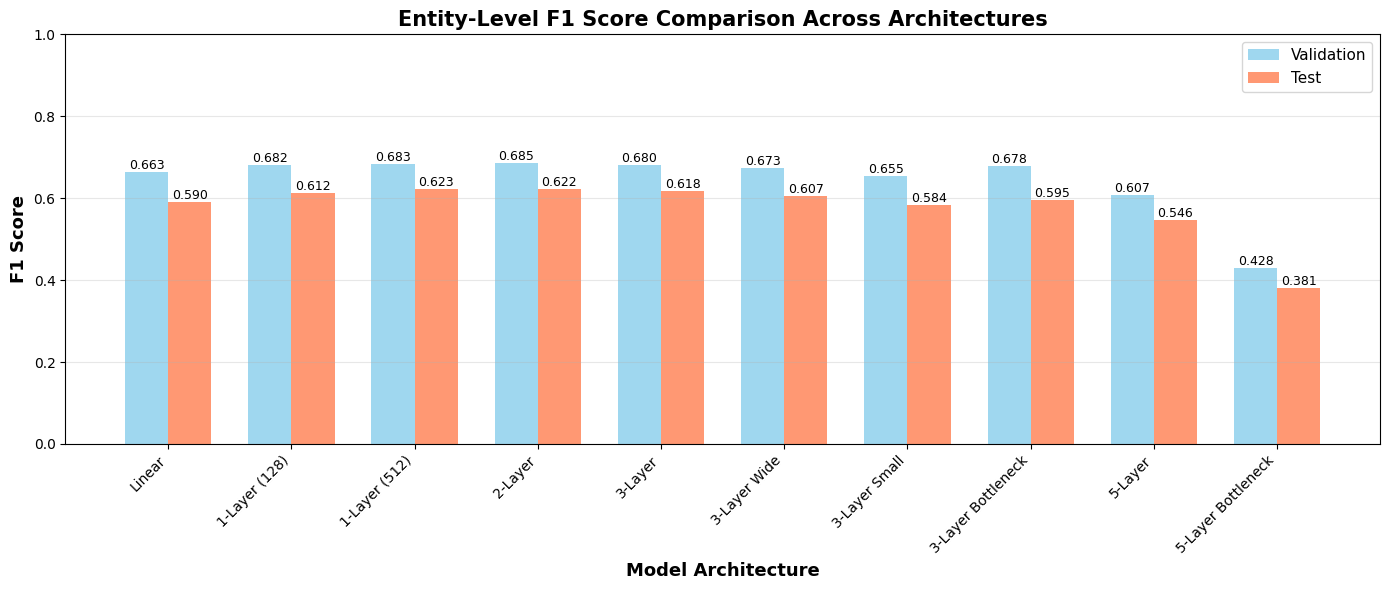

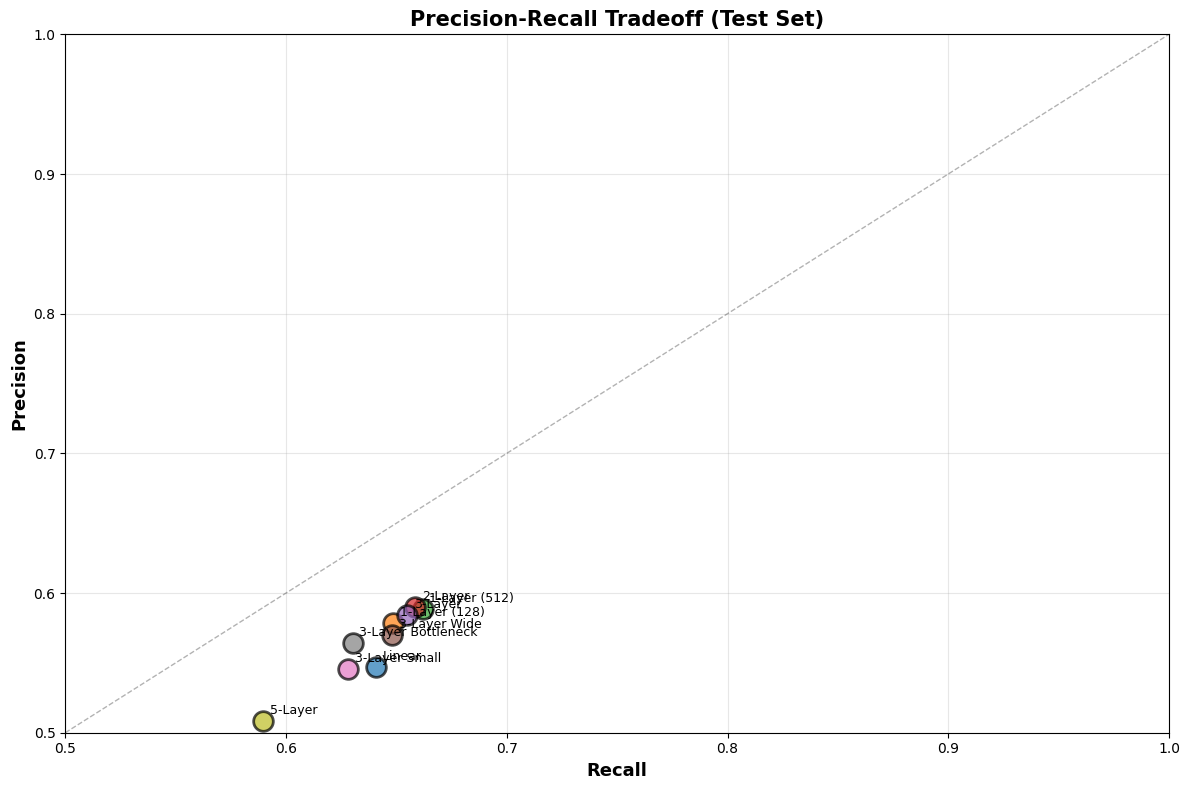

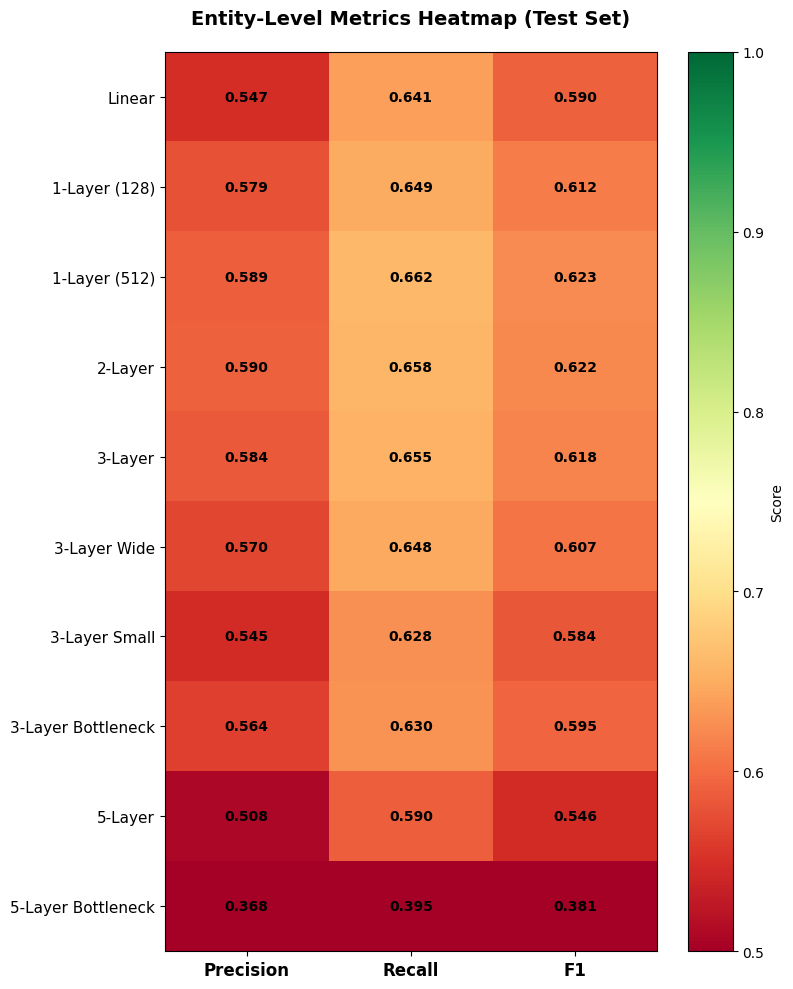


Model                     Val F1     Test F1    Test Prec    Test Recall 
Linear                    0.6634     0.5901     0.5469       0.6406      
1-Layer (128)             0.6819     0.6116     0.5787       0.6485      
1-Layer (512)             0.6827     0.6232     0.5888       0.6618      
2-Layer                   0.6850     0.6225     0.5903       0.6583      
3-Layer                   0.6803     0.6176     0.5843       0.6549      
3-Layer Wide              0.6726     0.6065     0.5700       0.6480      
3-Layer Small             0.6552     0.5838     0.5454       0.6280      
3-Layer Bottleneck        0.6776     0.5953     0.5642       0.6301      
5-Layer                   0.6075     0.5460     0.5084       0.5896      
5-Layer Bottleneck        0.4285     0.3809     0.3676       0.3952      

Best Model (Test F1): 1-Layer (512) (F1: 0.6232)


In [ ]:
# 1. F1 Score Comparison
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, val_f1, width, label='Validation', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, test_f1, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Model Architecture', fontsize=13, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
ax.set_title('Entity-Level F1 Score Comparison Across Architectures', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# 2. Precision-Recall Tradeoff (Test Set)
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

for i, (name, color) in enumerate(zip(model_names, colors)):
    ax.scatter(test_recall[i], test_precision[i], s=200, c=[color], 
               alpha=0.7, edgecolors='black', linewidth=2, label=name)
    ax.annotate(name, (test_recall[i], test_precision[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Tradeoff (Test Set)', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
# Diagonal line (F1 isolines could be added)
ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()


# 3. Metrics Heatmap
metrics_matrix = []
for name in model_names:
    row = [
        model_results[name]['test']['precision'],
        model_results[name]['test']['recall'],
        model_results[name]['test']['f1']
    ]
    metrics_matrix.append(row)

fig, ax = plt.subplots(figsize=(8, 10))
im = ax.imshow(metrics_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1)

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=12, fontweight='bold')
ax.set_yticklabels(model_names, fontsize=11)

# Add text annotations
for i in range(len(model_names)):
    for j in range(3):
        text = ax.text(j, i, f'{metrics_matrix[i][j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

ax.set_title('Entity-Level Metrics Heatmap (Test Set)', fontsize=14, fontweight='bold', pad=20)
fig.colorbar(im, ax=ax, label='Score')
plt.tight_layout()
plt.show()


# 4. Summary Table
print("\n" + "=" * 90)
print(f"{'Model':<25} {'Val F1':<10} {'Test F1':<10} {'Test Prec':<12} {'Test Recall':<12}")
print("=" * 90)
for name in model_names:
    print(f"{name:<25} "
          f"{model_results[name]['val']['f1']:<10.4f} "
          f"{model_results[name]['test']['f1']:<10.4f} "
          f"{model_results[name]['test']['precision']:<12.4f} "
          f"{model_results[name]['test']['recall']:<12.4f}")
print("=" * 90)

# Find best model
best_model = max(model_names, key=lambda x: model_results[x]['test']['f1'])
print(f"\nBest Model (Test F1): {best_model} (F1: {model_results[best_model]['test']['f1']:.4f})")

3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 

In [19]:
class MLPNER(nn.Module):
    """
    Multi-layer perceptron for Named Entity Recognition using GloVe embeddings with selectable activation function.
    Architecture: Embedding -> MLP (hidden layers) -> Logits
    """
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int, 
                 hidden_dims: list = [256, 128], dropout: float = 0.5, activation=nn.ReLU):
        """
        Args:
            embedding_matrix: Pre-trained GloVe embeddings
            num_tags: Number of NER tags (end dimension)
            hidden_dims: List of hidden layer dimensions (e.g., [256, 128] for 2 layers)
            dropout: Dropout probability for regularization, 0.5 because the paper I think used that
            activation: Activation function class to use (default: nn.ReLU)
        """
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        with torch.no_grad():
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        
        layers = []
        input_dim = embed_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(activation())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim

        self.mlp = nn.Sequential(*layers)
        
        # Final classifier
        self.classifier = nn.Linear(input_dim, num_tags)
    
    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, sequence_length)
        Returns:
            logits: (batch_size, sequence_length, num_tags)
        """
        # using the glove embeddings
        emb = self.embedding(input_ids)        # (B, T, D)
        # pass through MLP
        hidden = self.mlp(emb)                 # (B, T, H)
        # pass through final classifier
        logits = self.classifier(hidden)       # (B, T, C)
        return logits

### actiations functions

we'll procede excercise 3 with the best models for each number of hidden layers catagory
so the 1layer wide (512), 2layer (256-128) and 3layer (512-256-128)

activator functions: 
- RELU
- Leaky ReLU: An extension of ReLU, Leaky ReLU allows a small, non-zero gradient for negative inputs, preventing "dying ReLUs" where neurons can become inactive.
- Exponential Linear Unit (ELU): ELU also addresses the dying ReLU problem by introducing a smooth curve for negative inputs, providing more robust learning.
- Sigmoid


In [13]:
def train_model_with_val_loss(model, train_dataloader, val_dataloader, num_epochs=8, lr=1e-3, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), model_name="Model"):
    """
    Train a NER model and return training and validation losses per epoch.
    
    Args:
        model: The model to train
        train_dataloader: DataLoader for training data
        val_dataloader: DataLoader for validation data
        num_epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on
        model_name: Name for logging
    
    Returns:
        Tuple of (train_losses, val_losses) - lists of average losses per epoch
    """
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_epoch_losses = []
    val_epoch_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        
        for batch in tqdm(train_dataloader, desc=f"{model_name} - Training Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_epoch_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0.0
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"{model_name} - Validation Epoch {epoch+1}/{num_epochs}"):
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                
                logits = model(input_ids)
                loss = criterion(logits.view(-1, num_tags), labels.view(-1))
                
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_epoch_losses.append(avg_val_loss)
        
        # Print losses for this epoch
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    return train_epoch_losses, val_epoch_losses

In [17]:
def train_all_models(embedding_matrix, num_tags, train_dataloader, val_dataloader, device):
    """
    Train multiple NER model architectures with different activation functions.
    
    Args:
        embedding_matrix: Pre-trained GloVe embeddings
        num_tags: Number of NER tags
        train_dataloader: DataLoader for training data
        device: Device to train on (CPU/GPU)
    
    Returns:
        Tuple of (models_dict, losses_dict) containing trained models and their losses
    """
    
    model_configs = {
        # 1-Layer models with different activations
        '1-Layer (512) - LeakyReLU': {
            'hidden_dims': [512], 
            'activation': nn.LeakyReLU
        },
        '1-Layer (512) - ELU': {
            'hidden_dims': [512], 
            'activation': nn.ELU
        },
        '1-Layer (512) - Sigmoid': {
            'hidden_dims': [512], 
            'activation': nn.Sigmoid
        },
        
        # 2-Layer models with different activations
        '2-Layer (256-128) - LeakyReLU': {
            'hidden_dims': [256, 128], 
            'activation': nn.LeakyReLU
        },
        '2-Layer (256-128) - ELU': {
            'hidden_dims': [256, 128], 
            'activation': nn.ELU
        },
        '2-Layer (256-128) - Sigmoid': {
            'hidden_dims': [256, 128], 
            'activation': nn.Sigmoid
        },
        
        # 3-Layer models with different activations
        '3-Layer (512-256-128) - LeakyReLU': {
            'hidden_dims': [512, 256, 128], 
            'activation': nn.LeakyReLU
        },
        '3-Layer (512-256-128) - ELU': {
            'hidden_dims': [512, 256, 128], 
            'activation': nn.ELU
        },
        '3-Layer (512-256-128) - Sigmoid': {
            'hidden_dims': [512, 256, 128], 
            'activation': nn.Sigmoid
        },
    }
    
    models = {}
    losses = {}
    
    for name, config in model_configs.items():
        print(f"\n{'='*60}")
        print(f"Training: {name}")
        print(f"{'='*60}")
        
        # Set seed for reproducibility
        set_seed(42)
        
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Initialize model with specified activation function
        model = MLPNER(
            embedding_matrix, 
            num_tags, 
            hidden_dims=config['hidden_dims'],
            activation=config['activation']
        )
        
        # Train model
        train_losses, val_losses = train_model_with_val_loss(
            model, 
            train_dataloader,
            val_dataloader,
            model_name=name, 
            device=device
        )
        
        # Store results
        models[name] = model
        losses[name] = (train_losses, val_losses)
    
    return models, losses

In [20]:
# Train all model configurations with different activation functions

num_tags = len(conll2003["train"].features["ner_tags"].feature.names)
models, all_losses = train_all_models(embedding_matrix, num_tags, train_dataloader, val_dataloader, device)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)


Training: 1-Layer (512) - LeakyReLU


1-Layer (512) - LeakyReLU - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 759.59it/s]


1-Layer (512) - LeakyReLU - Epoch 1/8 - Train Loss: 0.3501 | Val Loss: 0.2436


1-Layer (512) - LeakyReLU - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 766.81it/s]


1-Layer (512) - LeakyReLU - Epoch 2/8 - Train Loss: 0.2051 | Val Loss: 0.2261


1-Layer (512) - LeakyReLU - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 762.06it/s]


1-Layer (512) - LeakyReLU - Epoch 3/8 - Train Loss: 0.1770 | Val Loss: 0.2175


1-Layer (512) - LeakyReLU - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 764.43it/s]


1-Layer (512) - LeakyReLU - Epoch 4/8 - Train Loss: 0.1610 | Val Loss: 0.2235


1-Layer (512) - LeakyReLU - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 769.04it/s]


1-Layer (512) - LeakyReLU - Epoch 5/8 - Train Loss: 0.1521 | Val Loss: 0.2218


1-Layer (512) - LeakyReLU - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 767.86it/s]


1-Layer (512) - LeakyReLU - Epoch 6/8 - Train Loss: 0.1476 | Val Loss: 0.2260


1-Layer (512) - LeakyReLU - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 767.36it/s]


1-Layer (512) - LeakyReLU - Epoch 7/8 - Train Loss: 0.1430 | Val Loss: 0.2291


1-Layer (512) - LeakyReLU - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 761.22it/s]


1-Layer (512) - LeakyReLU - Epoch 8/8 - Train Loss: 0.1403 | Val Loss: 0.2298

Training: 1-Layer (512) - ELU


1-Layer (512) - ELU - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 764.68it/s]


1-Layer (512) - ELU - Epoch 1/8 - Train Loss: 0.3524 | Val Loss: 0.2539


1-Layer (512) - ELU - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 765.91it/s]


1-Layer (512) - ELU - Epoch 2/8 - Train Loss: 0.2086 | Val Loss: 0.2361


1-Layer (512) - ELU - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 767.15it/s]


1-Layer (512) - ELU - Epoch 3/8 - Train Loss: 0.1782 | Val Loss: 0.2256


1-Layer (512) - ELU - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 765.62it/s]


1-Layer (512) - ELU - Epoch 4/8 - Train Loss: 0.1617 | Val Loss: 0.2339


1-Layer (512) - ELU - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 752.59it/s]


1-Layer (512) - ELU - Epoch 5/8 - Train Loss: 0.1536 | Val Loss: 0.2280


1-Layer (512) - ELU - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 756.19it/s]


1-Layer (512) - ELU - Epoch 6/8 - Train Loss: 0.1490 | Val Loss: 0.2322


1-Layer (512) - ELU - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 768.35it/s]


1-Layer (512) - ELU - Epoch 7/8 - Train Loss: 0.1452 | Val Loss: 0.2323


1-Layer (512) - ELU - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 765.80it/s]


1-Layer (512) - ELU - Epoch 8/8 - Train Loss: 0.1426 | Val Loss: 0.2374

Training: 1-Layer (512) - Sigmoid


1-Layer (512) - Sigmoid - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 762.14it/s]


1-Layer (512) - Sigmoid - Epoch 1/8 - Train Loss: 0.4347 | Val Loss: 0.2893


1-Layer (512) - Sigmoid - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 757.47it/s]


1-Layer (512) - Sigmoid - Epoch 2/8 - Train Loss: 0.2422 | Val Loss: 0.2455


1-Layer (512) - Sigmoid - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 768.33it/s]


1-Layer (512) - Sigmoid - Epoch 3/8 - Train Loss: 0.1985 | Val Loss: 0.2280


1-Layer (512) - Sigmoid - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 769.89it/s]


1-Layer (512) - Sigmoid - Epoch 4/8 - Train Loss: 0.1749 | Val Loss: 0.2266


1-Layer (512) - Sigmoid - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 763.30it/s]


1-Layer (512) - Sigmoid - Epoch 5/8 - Train Loss: 0.1615 | Val Loss: 0.2243


1-Layer (512) - Sigmoid - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 763.18it/s]


1-Layer (512) - Sigmoid - Epoch 6/8 - Train Loss: 0.1541 | Val Loss: 0.2278


1-Layer (512) - Sigmoid - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 750.45it/s]


1-Layer (512) - Sigmoid - Epoch 7/8 - Train Loss: 0.1480 | Val Loss: 0.2293


1-Layer (512) - Sigmoid - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 761.74it/s]


1-Layer (512) - Sigmoid - Epoch 8/8 - Train Loss: 0.1438 | Val Loss: 0.2309

Training: 2-Layer (256-128) - LeakyReLU


2-Layer (256-128) - LeakyReLU - Training Epoch 1/8: 100%|██████████| 439/439 [00:06<00:00, 72.18it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 744.06it/s]


2-Layer (256-128) - LeakyReLU - Epoch 1/8 - Train Loss: 0.4007 | Val Loss: 0.2618


2-Layer (256-128) - LeakyReLU - Training Epoch 2/8: 100%|██████████| 439/439 [00:06<00:00, 72.33it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 750.53it/s]


2-Layer (256-128) - LeakyReLU - Epoch 2/8 - Train Loss: 0.2372 | Val Loss: 0.2360


2-Layer (256-128) - LeakyReLU - Training Epoch 3/8: 100%|██████████| 439/439 [00:06<00:00, 72.07it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 749.34it/s]


2-Layer (256-128) - LeakyReLU - Epoch 3/8 - Train Loss: 0.2015 | Val Loss: 0.2302


2-Layer (256-128) - LeakyReLU - Training Epoch 4/8: 100%|██████████| 439/439 [00:06<00:00, 72.26it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 756.29it/s]


2-Layer (256-128) - LeakyReLU - Epoch 4/8 - Train Loss: 0.1814 | Val Loss: 0.2312


2-Layer (256-128) - LeakyReLU - Training Epoch 5/8: 100%|██████████| 439/439 [00:06<00:00, 72.34it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 754.46it/s]


2-Layer (256-128) - LeakyReLU - Epoch 5/8 - Train Loss: 0.1722 | Val Loss: 0.2306


2-Layer (256-128) - LeakyReLU - Training Epoch 6/8: 100%|██████████| 439/439 [00:06<00:00, 72.31it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 752.41it/s]


2-Layer (256-128) - LeakyReLU - Epoch 6/8 - Train Loss: 0.1640 | Val Loss: 0.2326


2-Layer (256-128) - LeakyReLU - Training Epoch 7/8: 100%|██████████| 439/439 [00:06<00:00, 72.21it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 753.23it/s]


2-Layer (256-128) - LeakyReLU - Epoch 7/8 - Train Loss: 0.1583 | Val Loss: 0.2418


2-Layer (256-128) - LeakyReLU - Training Epoch 8/8: 100%|██████████| 439/439 [00:06<00:00, 72.25it/s]
2-Layer (256-128) - LeakyReLU - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 750.24it/s]


2-Layer (256-128) - LeakyReLU - Epoch 8/8 - Train Loss: 0.1557 | Val Loss: 0.2422

Training: 2-Layer (256-128) - ELU


2-Layer (256-128) - ELU - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 751.83it/s]


2-Layer (256-128) - ELU - Epoch 1/8 - Train Loss: 0.3718 | Val Loss: 0.2609


2-Layer (256-128) - ELU - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 746.49it/s]


2-Layer (256-128) - ELU - Epoch 2/8 - Train Loss: 0.2274 | Val Loss: 0.2377


2-Layer (256-128) - ELU - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 749.70it/s]


2-Layer (256-128) - ELU - Epoch 3/8 - Train Loss: 0.1925 | Val Loss: 0.2308


2-Layer (256-128) - ELU - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 752.46it/s]


2-Layer (256-128) - ELU - Epoch 4/8 - Train Loss: 0.1753 | Val Loss: 0.2322


2-Layer (256-128) - ELU - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 748.75it/s]


2-Layer (256-128) - ELU - Epoch 5/8 - Train Loss: 0.1660 | Val Loss: 0.2296


2-Layer (256-128) - ELU - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 749.99it/s]


2-Layer (256-128) - ELU - Epoch 6/8 - Train Loss: 0.1584 | Val Loss: 0.2327


2-Layer (256-128) - ELU - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 749.32it/s]


2-Layer (256-128) - ELU - Epoch 7/8 - Train Loss: 0.1547 | Val Loss: 0.2356


2-Layer (256-128) - ELU - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 751.64it/s]


2-Layer (256-128) - ELU - Epoch 8/8 - Train Loss: 0.1525 | Val Loss: 0.2347

Training: 2-Layer (256-128) - Sigmoid


2-Layer (256-128) - Sigmoid - Training Epoch 1/8: 100%|██████████| 439/439 [00:06<00:00, 72.26it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 748.47it/s]


2-Layer (256-128) - Sigmoid - Epoch 1/8 - Train Loss: 0.5761 | Val Loss: 0.3711


2-Layer (256-128) - Sigmoid - Training Epoch 2/8: 100%|██████████| 439/439 [00:06<00:00, 72.32it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 755.60it/s]


2-Layer (256-128) - Sigmoid - Epoch 2/8 - Train Loss: 0.3061 | Val Loss: 0.2916


2-Layer (256-128) - Sigmoid - Training Epoch 3/8: 100%|██████████| 439/439 [00:06<00:00, 72.34it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 756.35it/s]


2-Layer (256-128) - Sigmoid - Epoch 3/8 - Train Loss: 0.2492 | Val Loss: 0.2647


2-Layer (256-128) - Sigmoid - Training Epoch 4/8: 100%|██████████| 439/439 [00:06<00:00, 72.39it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 757.27it/s]


2-Layer (256-128) - Sigmoid - Epoch 4/8 - Train Loss: 0.2174 | Val Loss: 0.2521


2-Layer (256-128) - Sigmoid - Training Epoch 5/8: 100%|██████████| 439/439 [00:06<00:00, 72.42it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 758.11it/s]


2-Layer (256-128) - Sigmoid - Epoch 5/8 - Train Loss: 0.2001 | Val Loss: 0.2465


2-Layer (256-128) - Sigmoid - Training Epoch 6/8: 100%|██████████| 439/439 [00:06<00:00, 72.29it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 758.61it/s]


2-Layer (256-128) - Sigmoid - Epoch 6/8 - Train Loss: 0.1868 | Val Loss: 0.2432


2-Layer (256-128) - Sigmoid - Training Epoch 7/8: 100%|██████████| 439/439 [00:06<00:00, 72.48it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 757.52it/s]


2-Layer (256-128) - Sigmoid - Epoch 7/8 - Train Loss: 0.1780 | Val Loss: 0.2441


2-Layer (256-128) - Sigmoid - Training Epoch 8/8: 100%|██████████| 439/439 [00:06<00:00, 72.45it/s]
2-Layer (256-128) - Sigmoid - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 755.96it/s]


2-Layer (256-128) - Sigmoid - Epoch 8/8 - Train Loss: 0.1715 | Val Loss: 0.2409

Training: 3-Layer (512-256-128) - LeakyReLU


3-Layer (512-256-128) - LeakyReLU - Training Epoch 1/8: 100%|██████████| 439/439 [00:06<00:00, 71.48it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 735.07it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 1/8 - Train Loss: 0.3963 | Val Loss: 0.2625


3-Layer (512-256-128) - LeakyReLU - Training Epoch 2/8: 100%|██████████| 439/439 [00:06<00:00, 71.53it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 736.82it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 2/8 - Train Loss: 0.2399 | Val Loss: 0.2375


3-Layer (512-256-128) - LeakyReLU - Training Epoch 3/8: 100%|██████████| 439/439 [00:06<00:00, 71.45it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 735.19it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 3/8 - Train Loss: 0.2050 | Val Loss: 0.2311


3-Layer (512-256-128) - LeakyReLU - Training Epoch 4/8: 100%|██████████| 439/439 [00:06<00:00, 71.44it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 733.33it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 4/8 - Train Loss: 0.1873 | Val Loss: 0.2332


3-Layer (512-256-128) - LeakyReLU - Training Epoch 5/8: 100%|██████████| 439/439 [00:06<00:00, 71.47it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 726.00it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 5/8 - Train Loss: 0.1766 | Val Loss: 0.2385


3-Layer (512-256-128) - LeakyReLU - Training Epoch 6/8: 100%|██████████| 439/439 [00:06<00:00, 71.44it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 734.89it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 6/8 - Train Loss: 0.1698 | Val Loss: 0.2324


3-Layer (512-256-128) - LeakyReLU - Training Epoch 7/8: 100%|██████████| 439/439 [00:06<00:00, 71.43it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 725.99it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 7/8 - Train Loss: 0.1635 | Val Loss: 0.2418


3-Layer (512-256-128) - LeakyReLU - Training Epoch 8/8: 100%|██████████| 439/439 [00:06<00:00, 71.45it/s]
3-Layer (512-256-128) - LeakyReLU - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 727.98it/s]


3-Layer (512-256-128) - LeakyReLU - Epoch 8/8 - Train Loss: 0.1602 | Val Loss: 0.2464

Training: 3-Layer (512-256-128) - ELU


3-Layer (512-256-128) - ELU - Training Epoch 1/8: 100%|██████████| 439/439 [00:06<00:00, 71.25it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 731.08it/s]


3-Layer (512-256-128) - ELU - Epoch 1/8 - Train Loss: 0.3586 | Val Loss: 0.2551


3-Layer (512-256-128) - ELU - Training Epoch 2/8: 100%|██████████| 439/439 [00:06<00:00, 71.36it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 738.30it/s]


3-Layer (512-256-128) - ELU - Epoch 2/8 - Train Loss: 0.2288 | Val Loss: 0.2379


3-Layer (512-256-128) - ELU - Training Epoch 3/8: 100%|██████████| 439/439 [00:06<00:00, 71.44it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 736.00it/s]


3-Layer (512-256-128) - ELU - Epoch 3/8 - Train Loss: 0.1968 | Val Loss: 0.2296


3-Layer (512-256-128) - ELU - Training Epoch 4/8: 100%|██████████| 439/439 [00:06<00:00, 71.51it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 734.61it/s]


3-Layer (512-256-128) - ELU - Epoch 4/8 - Train Loss: 0.1784 | Val Loss: 0.2365


3-Layer (512-256-128) - ELU - Training Epoch 5/8: 100%|██████████| 439/439 [00:06<00:00, 71.54it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 738.02it/s]


3-Layer (512-256-128) - ELU - Epoch 5/8 - Train Loss: 0.1697 | Val Loss: 0.2399


3-Layer (512-256-128) - ELU - Training Epoch 6/8: 100%|██████████| 439/439 [00:06<00:00, 71.62it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 739.61it/s]


3-Layer (512-256-128) - ELU - Epoch 6/8 - Train Loss: 0.1636 | Val Loss: 0.2342


3-Layer (512-256-128) - ELU - Training Epoch 7/8: 100%|██████████| 439/439 [00:06<00:00, 71.50it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 734.34it/s]


3-Layer (512-256-128) - ELU - Epoch 7/8 - Train Loss: 0.1589 | Val Loss: 0.2384


3-Layer (512-256-128) - ELU - Training Epoch 8/8: 100%|██████████| 439/439 [00:06<00:00, 71.45it/s]
3-Layer (512-256-128) - ELU - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 733.62it/s]


3-Layer (512-256-128) - ELU - Epoch 8/8 - Train Loss: 0.1560 | Val Loss: 0.2438

Training: 3-Layer (512-256-128) - Sigmoid


3-Layer (512-256-128) - Sigmoid - Training Epoch 1/8: 100%|██████████| 439/439 [00:06<00:00, 71.42it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 1/8: 100%|██████████| 102/102 [00:00<00:00, 733.63it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 1/8 - Train Loss: 0.5908 | Val Loss: 0.4518


3-Layer (512-256-128) - Sigmoid - Training Epoch 2/8: 100%|██████████| 439/439 [00:06<00:00, 71.44it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 2/8: 100%|██████████| 102/102 [00:00<00:00, 725.55it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 2/8 - Train Loss: 0.3757 | Val Loss: 0.3802


3-Layer (512-256-128) - Sigmoid - Training Epoch 3/8: 100%|██████████| 439/439 [00:06<00:00, 71.39it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 3/8: 100%|██████████| 102/102 [00:00<00:00, 734.26it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 3/8 - Train Loss: 0.2915 | Val Loss: 0.2979


3-Layer (512-256-128) - Sigmoid - Training Epoch 4/8: 100%|██████████| 439/439 [00:06<00:00, 71.50it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 4/8: 100%|██████████| 102/102 [00:00<00:00, 734.53it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 4/8 - Train Loss: 0.2495 | Val Loss: 0.2857


3-Layer (512-256-128) - Sigmoid - Training Epoch 5/8: 100%|██████████| 439/439 [00:06<00:00, 71.50it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 5/8: 100%|██████████| 102/102 [00:00<00:00, 737.92it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 5/8 - Train Loss: 0.2312 | Val Loss: 0.2809


3-Layer (512-256-128) - Sigmoid - Training Epoch 6/8: 100%|██████████| 439/439 [00:06<00:00, 71.47it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 6/8: 100%|██████████| 102/102 [00:00<00:00, 734.43it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 6/8 - Train Loss: 0.2200 | Val Loss: 0.2751


3-Layer (512-256-128) - Sigmoid - Training Epoch 7/8: 100%|██████████| 439/439 [00:06<00:00, 71.53it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 7/8: 100%|██████████| 102/102 [00:00<00:00, 733.43it/s]


3-Layer (512-256-128) - Sigmoid - Epoch 7/8 - Train Loss: 0.2108 | Val Loss: 0.2723


3-Layer (512-256-128) - Sigmoid - Training Epoch 8/8: 100%|██████████| 439/439 [00:06<00:00, 71.55it/s]
3-Layer (512-256-128) - Sigmoid - Validation Epoch 8/8: 100%|██████████| 102/102 [00:00<00:00, 738.24it/s]

3-Layer (512-256-128) - Sigmoid - Epoch 8/8 - Train Loss: 0.2018 | Val Loss: 0.2709

Training Complete!


In [109]:
%%capture
# briefly visualize f1 for these cute models
# Collect metrics for all models
print("Collecting metrics for all models...")
model_results_activations = {}
for name, model in models.items():
  model_results_activations[name] = entity_level_evaluation(model, verbose=False)

model_names = list(model_results_activations.keys())
val_f1 = [model_results_activations[m]['val']['f1'] for m in model_names]
test_f1 = [model_results_activations[m]['test']['f1'] for m in model_names]
val_precision = [model_results_activations[m]['val']['precision'] for m in model_names]
test_precision = [model_results_activations[m]['test']['precision'] for m in model_names]
val_recall = [model_results_activations[m]['val']['recall'] for m in model_names]
test_recall = [model_results_activations[m]['test']['recall'] for m in model_names]

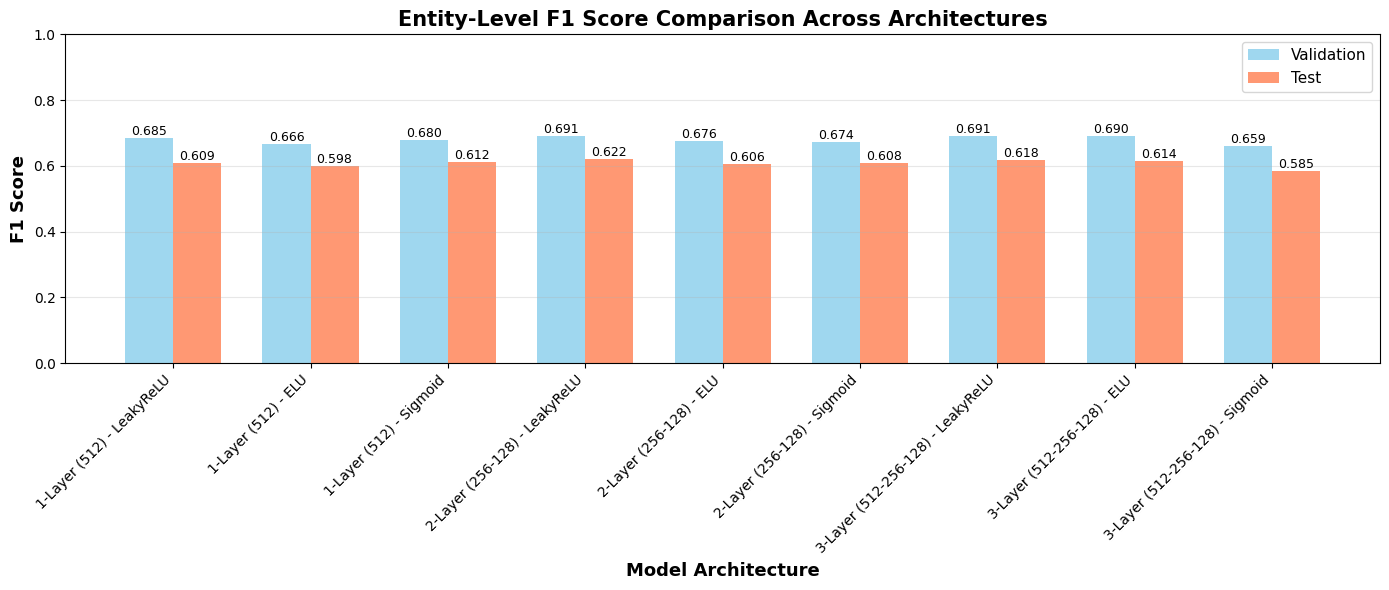

In [110]:
# 1. F1 Score Comparison
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, val_f1, width, label='Validation', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, test_f1, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Model Architecture', fontsize=13, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
ax.set_title('Entity-Level F1 Score Comparison Across Architectures', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### regularizations experiments

now to experiment with regularization methods we will take one of the mlp models with the highest overfitting, calculated as difference between the validation loss and training loss, and explore on it

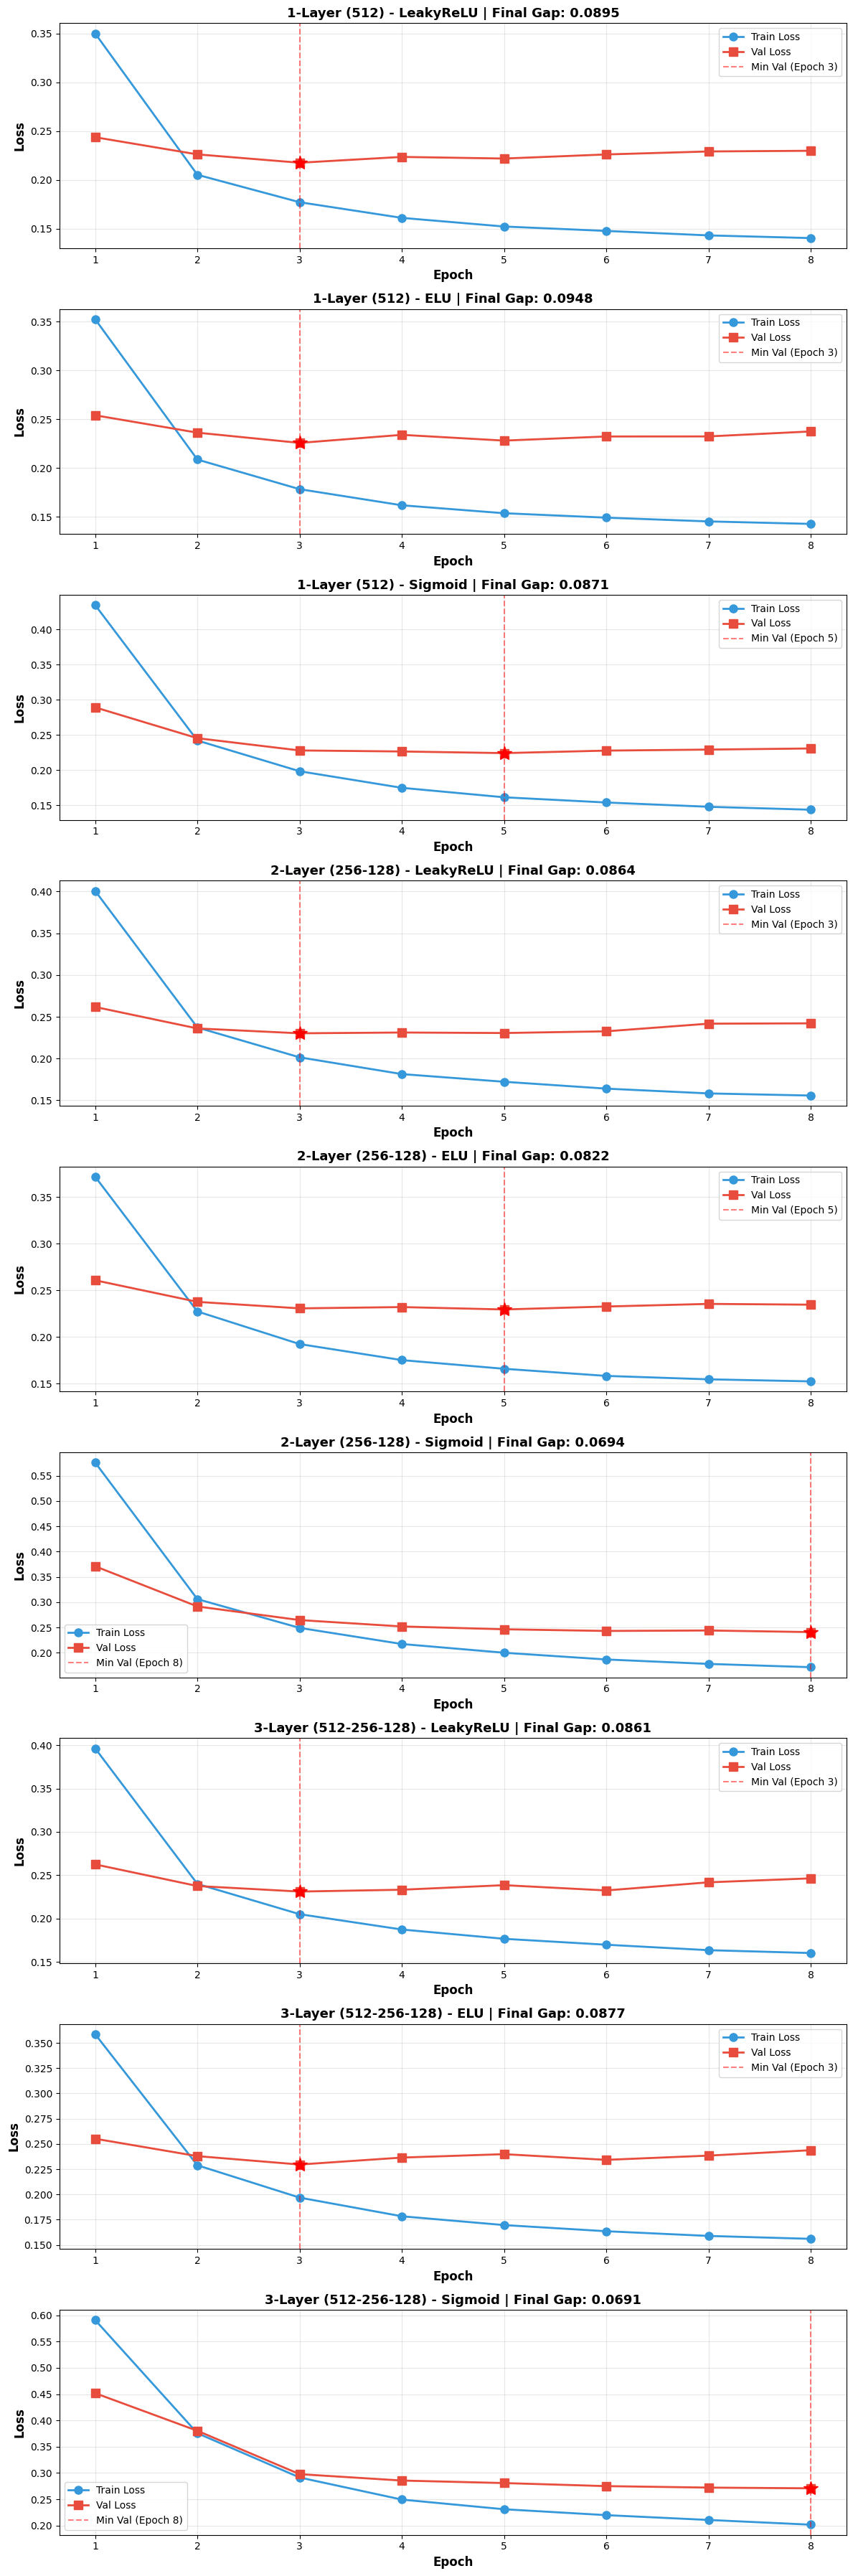

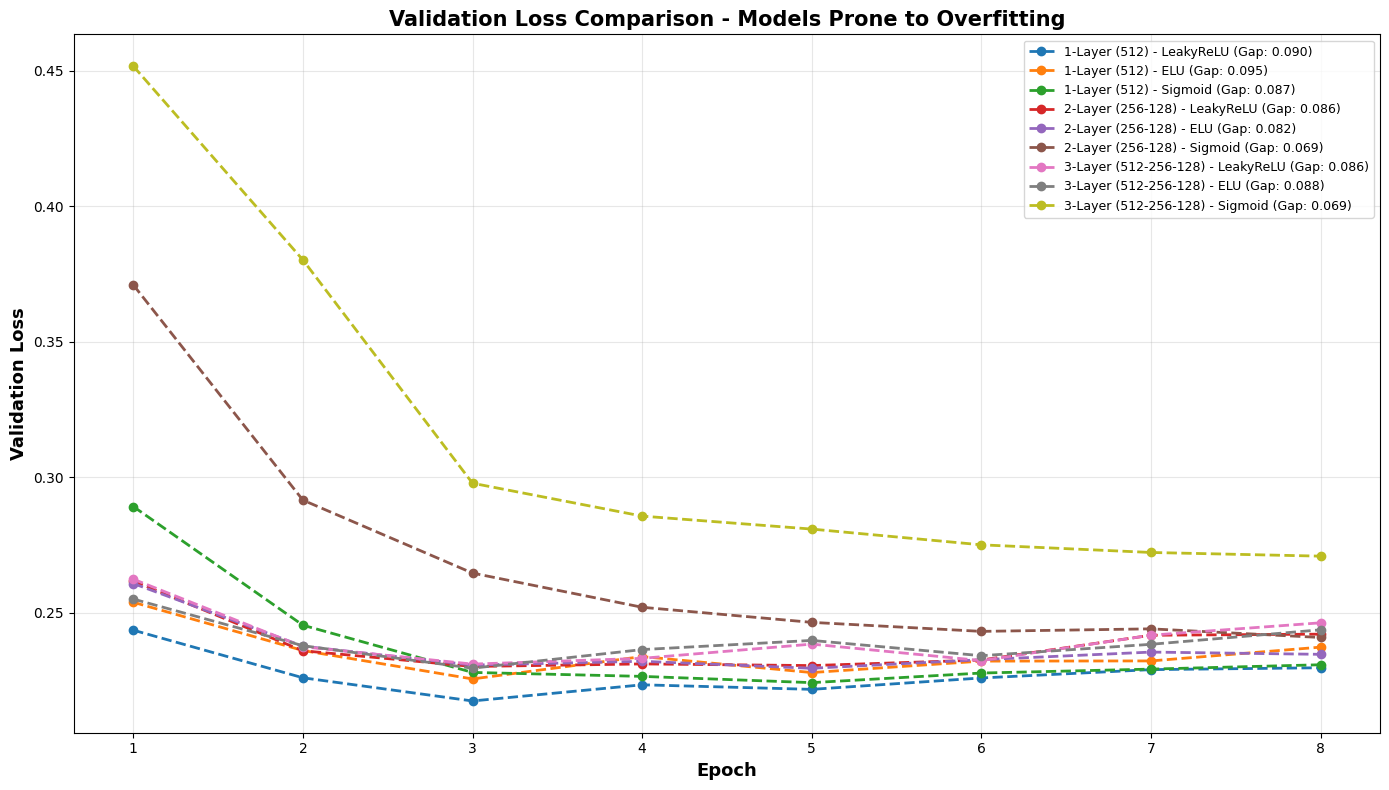

In [22]:
def plot_train_val_losses(all_losses, num_epochs=8):
    """
    Plot training and validation losses for all models.
    
    Args:
        all_losses: Dictionary of {model_name: (train_losses, val_losses)}
        num_epochs: Number of epochs (for x-axis)
    """
    n_models = len(all_losses)
    
    # Create subplots - one row per model
    fig, axes = plt.subplots(n_models, 1, figsize=(12, 4*n_models))
    epochs = range(1, num_epochs + 1)
    
    for idx, (model_name, (train_losses, val_losses)) in enumerate(all_losses.items()):
        ax = axes[idx]
        
        # Plot train and val losses
        ax.plot(epochs, train_losses, 'o-', label='Train Loss', linewidth=2, markersize=8, color='#3498db')
        ax.plot(epochs, val_losses, 's-', label='Val Loss', linewidth=2, markersize=8, color='#e74c3c')
        
        # Highlight minimum validation loss
        min_val_idx = np.argmin(val_losses)
        min_val_epoch = min_val_idx + 1
        min_val_loss = val_losses[min_val_idx]
        
        ax.axvline(x=min_val_epoch, color='red', linestyle='--', alpha=0.5, 
                   label=f'Min Val (Epoch {min_val_epoch})')
        ax.plot(min_val_epoch, min_val_loss, 'r*', markersize=15)
        
        # Calculate loss gap at final epoch
        loss_gap = val_losses[-1] - train_losses[-1]
        
        ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax.set_title(f'{model_name} | Final Gap: {loss_gap:.4f}', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(epochs)
    
    plt.tight_layout()
    plt.show()
    
    # Also create a summary comparison plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for model_name, (train_losses, val_losses) in all_losses.items():
        loss_gap = val_losses[-1] - train_losses[-1]
        linestyle = '--' if loss_gap > 0.05 else '-'
        
        # Plot validation loss
        ax.plot(epochs, val_losses, linestyle=linestyle, marker='o', 
               label=f'{model_name} (Gap: {loss_gap:.3f})', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax.set_ylabel('Validation Loss', fontsize=13, fontweight='bold')
    ax.set_title('Validation Loss Comparison - Models Prone to Overfitting', 
                fontsize=15, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(epochs)
    plt.tight_layout()
    plt.show()


# Use the function
plot_train_val_losses(all_losses)

I'll take the 3 layer elu as regularization should play a bigger role in deep models (i believe)

In [ ]:
# modified entity level evaluation function to return metrics also for the training f1 as it helps display overfitting
def entity_level_f1(model, train_dataloader=train_dataloader,val_dataloader=val_dataloader, test_dataloader=test_dataloader, tag_names=tag_names, device=device):
    """
    Evaluate model and optionally print results.
    Returns: dict with 'val' and 'test' metrics
    """
    train_metrics = compute_entity_f1(model, train_dataloader, tag_names, device)
    val_metrics = compute_entity_f1(model, val_dataloader, tag_names, device)
    test_metrics = compute_entity_f1(model, test_dataloader, tag_names, device)
    
    return {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}

In [29]:
def train_with_regularization(model, train_dataloader, config, num_epochs=8):
    """
    Unified training function with all regularization options.
    
    config = {
        'dropout': 0.5,
        'weight_decay': 0.01,
        'grad_clip': 1.0,
        'lr': 1e-3
    }
    """
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config.get('lr', 1e-3),
        weight_decay=config.get('weight_decay', 0.0)
    )
    model.to(device)
    
    epoch_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, num_tags), labels.view(-1))
            loss.backward()
            
            # Apply gradient clipping if specified
            if config.get('grad_clip') is not None:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), 
                    max_norm=config['grad_clip']
                )
            
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
    
    return epoch_losses

# Best combinations to test (5-6 experiments max)
regularization_experiments = {
    'Baseline': {
        'dropout': 0.5,
        'weight_decay': 0.0,
        'grad_clip': None,
    },
    'High-Dropout': {
        'dropout': 0.7,
        'weight_decay': 0.0,
        'grad_clip': None,
    },
    'L2-Only': {
        'dropout': 0.5,
        'weight_decay': 0.01,
        'grad_clip': None,
    },
    'Grad-Clip-Only': {
        'dropout': 0.5,
        'weight_decay': 0.0,
        'grad_clip': 1.0,
    },
    'Dropout+L2': {
        'dropout': 0.6,
        'weight_decay': 0.01,
        'grad_clip': None,
    },
    'All-Combined': {
        'dropout': 0.6,
        'weight_decay': 0.01,
        'grad_clip': 1.0,
    },
}

# Run experiments
results = {}
for name, config in regularization_experiments.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"Config: {config}")
    print(f"{'='*60}")
    
    set_seed(42)
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    model = MLPNER(embedding_matrix, num_tags, hidden_dims=[512, 256, 128], 
                   dropout=config['dropout'], activation=nn.ELU)
    
    losses = train_with_regularization(model, train_dataloader, config)
    metrics = entity_level_f1(model)
    
    results[name] = {
        'model': model,
        'losses': losses,
        'metrics': metrics,
        'config': config
    }


Training: Baseline
Config: {'dropout': 0.5, 'weight_decay': 0.0, 'grad_clip': None}


Epoch 1: 100%|██████████| 439/439 [00:06<00:00, 71.18it/s]


Epoch 1 - Loss: 0.3586


Epoch 2: 100%|██████████| 439/439 [00:06<00:00, 71.32it/s]


Epoch 2 - Loss: 0.2292


Epoch 3: 100%|██████████| 439/439 [00:06<00:00, 69.73it/s]


Epoch 3 - Loss: 0.1958


Epoch 4: 100%|██████████| 439/439 [00:06<00:00, 68.82it/s]


Epoch 4 - Loss: 0.1801


Epoch 5: 100%|██████████| 439/439 [00:06<00:00, 69.87it/s]


Epoch 5 - Loss: 0.1698


Epoch 6: 100%|██████████| 439/439 [00:06<00:00, 71.38it/s]


Epoch 6 - Loss: 0.1629


Epoch 7: 100%|██████████| 439/439 [00:06<00:00, 71.35it/s]


Epoch 7 - Loss: 0.1590


Epoch 8: 100%|██████████| 439/439 [00:06<00:00, 71.53it/s]


Epoch 8 - Loss: 0.1558


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 635.63it/s]



Training: High-Dropout
Config: {'dropout': 0.7, 'weight_decay': 0.0, 'grad_clip': None}


Epoch 1: 100%|██████████| 439/439 [00:06<00:00, 71.05it/s]


Epoch 1 - Loss: 0.4139


Epoch 2: 100%|██████████| 439/439 [00:06<00:00, 71.52it/s]


Epoch 2 - Loss: 0.2691


Epoch 3: 100%|██████████| 439/439 [00:06<00:00, 71.06it/s]


Epoch 3 - Loss: 0.2295


Epoch 4: 100%|██████████| 439/439 [00:06<00:00, 71.39it/s]


Epoch 4 - Loss: 0.2077


Epoch 5: 100%|██████████| 439/439 [00:06<00:00, 71.07it/s]


Epoch 5 - Loss: 0.1939


Epoch 6: 100%|██████████| 439/439 [00:06<00:00, 70.82it/s]


Epoch 6 - Loss: 0.1863


Epoch 7: 100%|██████████| 439/439 [00:06<00:00, 71.11it/s]


Epoch 7 - Loss: 0.1818


Epoch 8: 100%|██████████| 439/439 [00:06<00:00, 71.35it/s]


Epoch 8 - Loss: 0.1762


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 350.88it/s]



Training: L2-Only
Config: {'dropout': 0.5, 'weight_decay': 0.01, 'grad_clip': None}


Epoch 1: 100%|██████████| 439/439 [00:06<00:00, 62.82it/s]


Epoch 1 - Loss: 0.4800


Epoch 2: 100%|██████████| 439/439 [00:06<00:00, 63.12it/s]


Epoch 2 - Loss: 0.4374


Epoch 3: 100%|██████████| 439/439 [00:06<00:00, 63.09it/s]


Epoch 3 - Loss: 0.4342


Epoch 4: 100%|██████████| 439/439 [00:06<00:00, 63.11it/s]


Epoch 4 - Loss: 0.4432


Epoch 5: 100%|██████████| 439/439 [00:06<00:00, 63.10it/s]


Epoch 5 - Loss: 0.4630


Epoch 6: 100%|██████████| 439/439 [00:06<00:00, 63.10it/s]


Epoch 6 - Loss: 0.4649


Epoch 7: 100%|██████████| 439/439 [00:06<00:00, 63.10it/s]


Epoch 7 - Loss: 0.4660


Epoch 8: 100%|██████████| 439/439 [00:06<00:00, 63.11it/s]


Epoch 8 - Loss: 0.4640


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 636.67it/s]



Training: Grad-Clip-Only
Config: {'dropout': 0.5, 'weight_decay': 0.0, 'grad_clip': 1.0}


Epoch 1: 100%|██████████| 439/439 [00:06<00:00, 62.79it/s]


Epoch 1 - Loss: 0.3526


Epoch 2: 100%|██████████| 439/439 [00:06<00:00, 62.83it/s]


Epoch 2 - Loss: 0.2282


Epoch 3: 100%|██████████| 439/439 [00:06<00:00, 62.83it/s]


Epoch 3 - Loss: 0.1954


Epoch 4: 100%|██████████| 439/439 [00:06<00:00, 62.86it/s]


Epoch 4 - Loss: 0.1798


Epoch 5: 100%|██████████| 439/439 [00:06<00:00, 62.83it/s]


Epoch 5 - Loss: 0.1695


Epoch 6: 100%|██████████| 439/439 [00:06<00:00, 62.84it/s]


Epoch 6 - Loss: 0.1628


Epoch 7: 100%|██████████| 439/439 [00:06<00:00, 62.85it/s]


Epoch 7 - Loss: 0.1588


Epoch 8: 100%|██████████| 439/439 [00:06<00:00, 62.83it/s]


Epoch 8 - Loss: 0.1556


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 627.83it/s]



Training: Dropout+L2
Config: {'dropout': 0.6, 'weight_decay': 0.01, 'grad_clip': None}


Epoch 1: 100%|██████████| 439/439 [00:06<00:00, 63.03it/s]


Epoch 1 - Loss: 0.4930


Epoch 2: 100%|██████████| 439/439 [00:06<00:00, 63.05it/s]


Epoch 2 - Loss: 0.4441


Epoch 3: 100%|██████████| 439/439 [00:06<00:00, 63.06it/s]


Epoch 3 - Loss: 0.4383


Epoch 4: 100%|██████████| 439/439 [00:06<00:00, 62.96it/s]


Epoch 4 - Loss: 0.4464


Epoch 5: 100%|██████████| 439/439 [00:06<00:00, 62.99it/s]


Epoch 5 - Loss: 0.4655


Epoch 6: 100%|██████████| 439/439 [00:06<00:00, 63.06it/s]


Epoch 6 - Loss: 0.4671


Epoch 7: 100%|██████████| 439/439 [00:06<00:00, 63.08it/s]


Epoch 7 - Loss: 0.4681


Epoch 8: 100%|██████████| 439/439 [00:06<00:00, 63.07it/s]


Epoch 8 - Loss: 0.4658


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 634.50it/s]



Training: All-Combined
Config: {'dropout': 0.6, 'weight_decay': 0.01, 'grad_clip': 1.0}


Epoch 1: 100%|██████████| 439/439 [00:07<00:00, 56.27it/s]


Epoch 1 - Loss: 0.4887


Epoch 2: 100%|██████████| 439/439 [00:07<00:00, 56.27it/s]


Epoch 2 - Loss: 0.4434


Epoch 3: 100%|██████████| 439/439 [00:07<00:00, 56.28it/s]


Epoch 3 - Loss: 0.4376


Epoch 4: 100%|██████████| 439/439 [00:07<00:00, 56.32it/s]


Epoch 4 - Loss: 0.4461


Epoch 5: 100%|██████████| 439/439 [00:07<00:00, 56.29it/s]


Epoch 5 - Loss: 0.4653


Epoch 6: 100%|██████████| 439/439 [00:07<00:00, 56.27it/s]


Epoch 6 - Loss: 0.4669


Epoch 7: 100%|██████████| 439/439 [00:07<00:00, 56.31it/s]


Epoch 7 - Loss: 0.4681


Epoch 8: 100%|██████████| 439/439 [00:07<00:00, 56.29it/s]


Epoch 8 - Loss: 0.4659


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 632.13it/s]


In [30]:
results_df = pd.DataFrame.from_dict({name: {
        'Train F1': res['metrics']['train']['f1'],
        'Val F1': res['metrics']['val']['f1'],
        'Test F1': res['metrics']['test']['f1'],
        'Difference': res['metrics']['train']['f1'] - res['metrics']['val']['f1'],
        'Config': res['config']
    } for name, res in results.items()}, orient='index')
print("\nRegularization Experiment Results:")
print(results_df)


Regularization Experiment Results:
                Train F1    Val F1   Test F1  Difference  \
Baseline        0.740368  0.682261  0.608152    0.058107   
High-Dropout    0.737362  0.677813  0.598505    0.059549   
L2-Only         0.279487  0.279953  0.273533   -0.000466   
Grad-Clip-Only  0.741212  0.682040  0.609525    0.059173   
Dropout+L2      0.280392  0.281785  0.273575   -0.001392   
All-Combined    0.281028  0.282642  0.273329   -0.001614   

                                                           Config  
Baseline        {'dropout': 0.5, 'weight_decay': 0.0, 'grad_cl...  
High-Dropout    {'dropout': 0.7, 'weight_decay': 0.0, 'grad_cl...  
L2-Only         {'dropout': 0.5, 'weight_decay': 0.01, 'grad_c...  
Grad-Clip-Only  {'dropout': 0.5, 'weight_decay': 0.0, 'grad_cl...  
Dropout+L2      {'dropout': 0.6, 'weight_decay': 0.01, 'grad_c...  
All-Combined    {'dropout': 0.6, 'weight_decay': 0.01, 'grad_c...  


brief analysis:
the baseline model had a reasonable overfitting value, 0.05 difference, it was generalizing moderately.

applying aggressive regularization techniques led not only to underfitting I think but to straight not learning: a random guesser could have reached an f1 score of 0.28.

less aggressive methods (high dropout) didnt produce any change, while L2 was catastrophic: The penalty for any non-zero weight became so massive that the optimizer's best strategy was to make all weights in the MLP as close to zero as possible, thus nullifying learning.

### last step: visualization of embedding space

we'll not work on the models from the regularization techniques section as most of them are unusable and the other part doesnt provide substantial change / I would not be able to descriminate between what is caused by the regularization and whats done by the baseline itself.

In [41]:
# Select best model based on test F1 from phase 2 of the homework
model = model_3layer


Comparing Entity Embeddings Across Different Activation Functions

Processing: 2-Layer ReLU


Extracting embeddings:  33%|███▎      | 36/108 [00:00<00:00, 103.63it/s]

Extracted 3000 entity embeddings
Embedding dimension: 128


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

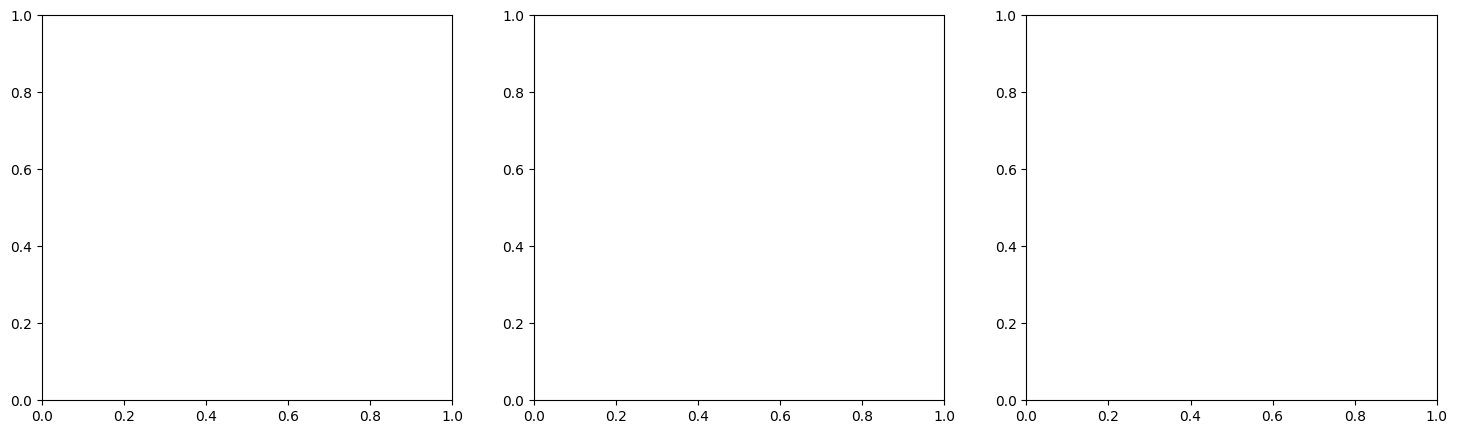

In [111]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def extract_entity_embeddings(model, dataloader, tag_names, device, max_samples=5000):
    """
    Extract embeddings for entity tokens (non-O tags) from a trained model.
    
    Args:
        model: Trained NER model
        dataloader: DataLoader with data
        tag_names: List of NER tag names
        device: Device to run on
        max_samples: Maximum number of entity tokens to extract
    
    Returns:
        embeddings: numpy array of shape (n_samples, hidden_dim)
        labels: list of entity type labels (e.g., 'PER', 'ORG', 'LOC', 'MISC')
        tags: list of full tag names (e.g., 'B-PER', 'I-LOC')
    """
    model.eval()
    
    embeddings_list = []
    labels_list = []
    tags_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            if len(embeddings_list) >= max_samples:
                break
                
            input_ids = batch["input_ids"].to(device)
            ner_labels = batch["labels"].to(device)
            
            # Forward pass through embedding and MLP layers
            emb = model.embedding(input_ids)  # (B, T, D)
            hidden = model.mlp(emb)           # (B, T, H)
            
            # Process each sequence in batch
            for seq_idx in range(hidden.shape[0]):
                for token_idx in range(hidden.shape[1]):
                    label_id = ner_labels[seq_idx, token_idx].item()
                    
                    # Skip padding tokens and 'O' (outside) tags
                    if label_id == -100 or label_id == 0:
                        continue
                    
                    # Extract the hidden representation for this token
                    token_embedding = hidden[seq_idx, token_idx].cpu().numpy()
                    tag = tag_names[label_id]
                    
                    # Extract entity type (PER, ORG, LOC, MISC)
                    if tag.startswith('B-') or tag.startswith('I-'):
                        entity_type = tag[2:]  # Remove 'B-' or 'I-' prefix
                    else:
                        entity_type = 'O'
                    
                    embeddings_list.append(token_embedding)
                    labels_list.append(entity_type)
                    tags_list.append(tag)
                    
                    if len(embeddings_list) >= max_samples:
                        break
                if len(embeddings_list) >= max_samples:
                    break
    
    return np.array(embeddings_list), labels_list, tags_list


def visualize_embeddings_comparison(models_dict, dataloader, tag_names, device, 
                                   method='tsne', max_samples=3000):
    """
    Create comparison visualizations of entity embeddings from multiple models.
    
    Args:
        models_dict: Dictionary of {model_name: model}
        dataloader: DataLoader with data
        tag_names: List of NER tag names
        device: Device to run on
        method: 'pca', 'tsne', or 'umap'
        max_samples: Maximum samples to extract per model
    """
    # Entity type colors
    entity_colors = {
        'PER': '#FF6B6B',   # Red for Person
        'ORG': '#4ECDC4',   # Teal for Organization
        'LOC': '#45B7D1',   # Blue for Location
        'MISC': '#FFA07A'   # Orange for Miscellaneous
    }
    
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        print(f"\n{'='*60}")
        print(f"Processing: {model_name}")
        print(f"{'='*60}")
        
        # Extract embeddings
        embeddings, labels, tags = extract_entity_embeddings(
            model, dataloader, tag_names, device, max_samples
        )
        
        print(f"Extracted {len(embeddings)} entity embeddings")
        print(f"Embedding dimension: {embeddings.shape[1]}")
        
        # Apply dimensionality reduction
        if method == 'pca':
            reducer = PCA(n_components=2, random_state=42)
            title_method = 'PCA'
        elif method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
            title_method = 't-SNE'
        elif method == 'umap':
            reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
            title_method = 'UMAP'
        else:
            raise ValueError("method must be 'pca', 'tsne', or 'umap'")
        
        print(f"Applying {title_method}...")
        embeddings_2d = reducer.fit_transform(embeddings)
        
        # Plot
        ax = axes[idx]
        
        for entity_type in ['PER', 'ORG', 'LOC', 'MISC']:
            mask = np.array([l == entity_type for l in labels])
            if mask.sum() > 0:
                ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                          c=entity_colors[entity_type], label=entity_type,
                          alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
        
        ax.set_title(f'{title_method}: {model_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{title_method} Component 1', fontsize=10)
        ax.set_ylabel(f'{title_method} Component 2', fontsize=10)
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def visualize_single_model_detailed(model, model_name, dataloader, tag_names, device, max_samples=3000):
    """
    Create detailed visualizations for a single model with all three reduction methods.
    
    Args:
        model: Trained NER model
        model_name: Name of the model for titles
        dataloader: DataLoader with data
        tag_names: List of NER tag names
        device: Device to run on
        max_samples: Maximum samples to extract
    """
    print(f"\n{'='*70}")
    print(f"Detailed Visualization for: {model_name}")
    print(f"{'='*70}")
    
    # Extract embeddings once
    embeddings, labels, tags = extract_entity_embeddings(
        model, dataloader, tag_names, device, max_samples
    )
    
    print(f"Extracted {len(embeddings)} entity embeddings")
    print(f"Embedding dimension: {embeddings.shape[1]}")
    
    # Count entities
    from collections import Counter
    entity_counts = Counter(labels)
    print("\nEntity distribution:")
    for entity, count in entity_counts.most_common():
        print(f"  {entity}: {count}")
    
    # Entity type colors
    entity_colors = {
        'PER': '#FF6B6B',
        'ORG': '#4ECDC4',
        'LOC': '#45B7D1',
        'MISC': '#FFA07A'
    }
    
    # Create 3 subplots for different methods
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    methods = [
        ('pca', PCA(n_components=2, random_state=42)),
        ('tsne', TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)),
        ('umap', umap.UMAP(n_components=2, random_state=42, n_neighbors=15))
    ]
    
    for idx, (method_name, reducer) in enumerate(methods):
        print(f"\nApplying {method_name.upper()}...")
        embeddings_2d = reducer.fit_transform(embeddings)
        
        ax = axes[idx]
        
        for entity_type in ['PER', 'ORG', 'LOC', 'MISC']:
            mask = np.array([l == entity_type for l in labels])
            if mask.sum() > 0:
                ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                          c=entity_colors[entity_type], label=f'{entity_type} ({mask.sum()})',
                          alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
        
        ax.set_title(f'{method_name.upper()}', fontsize=14, fontweight='bold')
        ax.set_xlabel(f'{method_name.upper()} Component 1', fontsize=11)
        ax.set_ylabel(f'{method_name.upper()} Component 2', fontsize=11)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'Entity Embeddings: {model_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Also create B- vs I- comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    bi_colors = {
        'B-PER': '#FF0000', 'I-PER': '#FFB3B3',
        'B-ORG': '#00CED1', 'I-ORG': '#B3E5E6',
        'B-LOC': '#0000FF', 'I-LOC': '#B3B3FF',
        'B-MISC': '#FF8C00', 'I-MISC': '#FFD9B3'
    }
    
    for idx, (method_name, reducer) in enumerate(methods):
        embeddings_2d = reducer.fit_transform(embeddings)
        
        ax = axes[idx]
        
        for tag in ['B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']:
            mask = np.array([t == tag for t in tags])
            if mask.sum() > 0:
                marker = 'o' if tag.startswith('B-') else '^'
                ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                          c=bi_colors[tag], label=tag, marker=marker,
                          alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
        
        ax.set_title(f'{method_name.upper()} - B-/I- Tags', fontsize=14, fontweight='bold')
        ax.set_xlabel(f'{method_name.upper()} Component 1', fontsize=11)
        ax.set_ylabel(f'{method_name.upper()} Component 2', fontsize=11)
        ax.legend(fontsize=8, loc='best', ncol=2)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'Begin vs Inside Tags: {model_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Example usage:

# 1. Compare embeddings from models with different activation functions using t-SNE
print("\n" + "="*70)
print("Comparing Entity Embeddings Across Different Activation Functions")
print("="*70)

models_to_compare = {
    '2-Layer ReLU': model_2layer,
    '2-Layer LeakyReLU': models['2-Layer (256-128) - LeakyReLU'],
    '2-Layer ELU': models['2-Layer (256-128) - ELU'],
}

visualize_embeddings_comparison(models_to_compare, test_dataloader, tag_names, device, method='tsne')

# 2. Detailed visualization for best model
print("\n" + "="*70)
print("Detailed Analysis of Best Performing Model")
print("="*70)

visualize_single_model_detailed(
    model_3layer, 
    '3-Layer (512-256-128) with ReLU', 
    test_dataloader, 
    tag_names, 
    device
)

# 3. Compare architecture depths
print("\n" + "="*70)
print("Comparing Different Model Depths")
print("="*70)

depth_comparison = {
    '1-Layer': model_onelayer_wide,
    '2-Layer': model_2layer,
    '3-Layer': model_3layer,
}

visualize_embeddings_comparison(depth_comparison, test_dataloader, tag_names, device, method='umap')